# Importation des librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import parallel_coordinates
from matplotlib.collections import LineCollection

# Fonctions

In [2]:
def check_key(df,column):
    if df.size==df.drop_duplicates(column).size:
        print("key ok")
    else: 
        print("key ko")

In [3]:
def check_null(df,column):
    if df[column].size==df[column].dropna().size:
        print("no null ok")
    else: 
        print("no null ko")

In [4]:
# Création definition pour plot dendrogramme
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.axvline(x=10, color='black', linestyle='-')
    plt.show()

In [5]:
# definitions d'une fonction pour l'éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [6]:
# Pour projection ACP
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [7]:
# colors
def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

In [8]:
def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)

In [9]:
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20) 

In [10]:
palette = sns.color_palette("bright", 10)

In [11]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)

# Importation des données

In [12]:
dispo_alim=pd.read_csv('/Users/anapereira/Desktop/Projets/projet 9/DAN-P9-data/DisponibiliteAlimentaire_2017.csv')

In [13]:
pop=pd.read_csv('/Users/anapereira/Desktop/Projets/projet 9/DAN-P9-data/Population_2000_2018.csv')

In [14]:
# données supplémentaires sur PIB source FAO
df_PIB=pd.read_csv('/Users/anapereira/Desktop/Projets/projet 9/data en plus FAO/PIB.csv')

In [15]:
# données supplémentaires sur la stabilité politique
politic_stability=pd.read_csv('/Users/anapereira/Desktop/Projets/projet 9/data en plus FAO/PoliticalStability.csv')

In [16]:
# données supplémentaires sur la sous-nutrition
sous_nut=pd.read_csv('/Users/anapereira/Desktop/Projets/projet 9/data en plus FAO/sousnut2017.csv')

# Exploration des données

## df dispo_alimentaire

In [17]:
# df dispo alimentaire
dispo_alim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Code Domaine            176600 non-null  object 
 1   Domaine                 176600 non-null  object 
 2   Code zone               176600 non-null  int64  
 3   Zone                    176600 non-null  object 
 4   Code Élément            176600 non-null  int64  
 5   Élément                 176600 non-null  object 
 6   Code Produit            176600 non-null  int64  
 7   Produit                 176600 non-null  object 
 8   Code année              176600 non-null  int64  
 9   Année                   176600 non-null  int64  
 10  Unité                   176600 non-null  object 
 11  Valeur                  176600 non-null  float64
 12  Symbole                 176600 non-null  object 
 13  Description du Symbole  176600 non-null  object 
dtypes: float64(1), int64

In [18]:
dispo_alim['Produit'].unique()

array(['Blé et produits', 'Riz et produits', 'Orge et produits',
       'Maïs et produits', 'Seigle et produits', 'Avoine',
       'Millet et produits', 'Sorgho et produits', 'Céréales, Autres',
       'Pommes de Terre et produits', 'Ignames', 'Racines nda',
       'Sucre, canne', 'Sucre, betterave', 'Sucre Eq Brut',
       'Edulcorants Autres', 'Miel', 'Haricots', 'Pois',
       'Légumineuses Autres et produits', 'Noix et produits', 'Soja',
       'Arachides Decortiquees', 'Graines de tournesol',
       'Graines Colza/Moutarde', 'Graines de coton', 'Coco (Incl Coprah)',
       'Sésame', 'Olives', 'Plantes Oleiferes, Autre', 'Huile de Soja',
       "Huile d'Arachide", 'Huile de Tournesol',
       'Huile de Colza&Moutarde', 'Huile Graines de Coton',
       'Huile de Palmistes', 'Huile de Palme', 'Huile de Coco',
       'Huile de Sésame', "Huile d'Olive", 'Huile de Son de Riz',
       'Huile de Germe de Maïs', 'Huil Plantes Oleif Autr',
       'Tomates et produits', 'Oignons', 'Légumes, 

In [19]:
dispo_alim['Élément'].unique()

array(['Production', 'Importations - Quantité', 'Variation de stock',
       'Exportations - Quantité', 'Disponibilité intérieure',
       'Aliments pour animaux', 'Semences', 'Pertes', 'Résidus',
       'Nourriture',
       'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité de matière grasse en quantité (g/personne/jour)',
       'Traitement', 'Autres utilisations (non alimentaire)',
       'Alimentation pour touristes'], dtype=object)

In [20]:
# année des données ?
dispo_alim['Année'].unique()

array([2017])

In [21]:
df_volaille = dispo_alim[dispo_alim['Produit']=='Viande de Volailles']
df_volaille

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
651,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28.00,S,Données standardisées
652,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29.00,S,Données standardisées
653,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2734,Viande de Volailles,2017,2017,Milliers de tonnes,0.00,S,Données standardisées
654,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2734,Viande de Volailles,2017,2017,Milliers de tonnes,57.00,S,Données standardisées
655,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5123,Pertes,2734,Viande de Volailles,2017,2017,Milliers de tonnes,2.00,S,Données standardisées
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176396,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,5142,Nourriture,2734,Viande de Volailles,2017,2017,Milliers de tonnes,67.00,S,Données standardisées
176397,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,645,Disponibilité alimentaire en quantité (kg/pers...,2734,Viande de Volailles,2017,2017,kg,4.68,Fc,Donnée calculée
176398,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,664,Disponibilité alimentaire (Kcal/personne/jour),2734,Viande de Volailles,2017,2017,Kcal/personne/jour,16.00,Fc,Donnée calculée
176399,FBS,Nouveaux Bilans Alimentaire,181,Zimbabwe,674,Disponibilité de protéines en quantité (g/pers...,2734,Viande de Volailles,2017,2017,g/personne/jour,1.59,Fc,Donnée calculée


In [22]:
viande_volaille=df_volaille[['Zone','Élément','Valeur']]
viande_volaille

,Zone,Élément,Valeur
651,Afghanistan,Production,28.00
652,Afghanistan,Importations - Quantité,29.00
653,Afghanistan,Variation de stock,0.00
654,Afghanistan,Disponibilité intérieure,57.00
655,Afghanistan,Pertes,2.00
...,...,...,...
176396,Zimbabwe,Nourriture,67.00
176397,Zimbabwe,Disponibilité alimentaire en quantité (kg/pers...,4.68
176398,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),16.00
176399,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,1.59


In [23]:
df_volaille=viande_volaille.pivot(index='Zone', columns='Élément', values='Valeur')
df_volaille

Élément,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
Zone,,,,,,,,,,,,,,,,,
Afghanistan,NaN,NaN,NaN,5.0,1.53,0.33,0.54,57.0,NaN,29.0,55.0,2.0,28.0,0.0,NaN,NaN,0.0
Afrique du Sud,0.0,NaN,NaN,143.0,35.69,9.25,14.11,2118.0,63.0,514.0,2035.0,83.0,1667.0,0.0,NaN,NaN,-0.0
Albanie,NaN,NaN,NaN,85.0,16.36,6.45,6.26,47.0,0.0,38.0,47.0,NaN,13.0,0.0,NaN,NaN,4.0
Algérie,0.0,NaN,NaN,22.0,6.38,1.50,1.97,277.0,0.0,2.0,264.0,13.0,275.0,0.0,NaN,NaN,0.0
Allemagne,NaN,NaN,NaN,71.0,19.47,4.16,7.96,1739.0,646.0,842.0,1609.0,NaN,1514.0,-38.0,NaN,167.0,-29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,NaN,NaN,NaN,147.0,43.47,9.25,14.80,412.0,94.0,433.0,412.0,NaN,48.0,-0.0,NaN,NaN,-26.0
Équateur,0.0,NaN,NaN,83.0,19.31,6.35,6.15,341.0,0.0,0.0,324.0,17.0,340.0,0.0,NaN,NaN,-1.0
États-Unis d'Amérique,NaN,NaN,89.0,219.0,55.68,14.83,19.93,18266.0,3692.0,123.0,18100.0,NaN,21914.0,-0.0,NaN,77.0,80.0


In [24]:
df_volaille.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to Îles Salomon
Data columns (total 17 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Alimentation pour touristes                                    78 non-null     float64
 1   Aliments pour animaux                                          1 non-null      float64
 2   Autres utilisations (non alimentaire)                          34 non-null     float64
 3   Disponibilité alimentaire (Kcal/personne/jour)                 172 non-null    float64
 4   Disponibilité alimentaire en quantité (kg/personne/an)         172 non-null    float64
 5   Disponibilité de matière grasse en quantité (g/personne/jour)  172 non-null    float64
 6   Disponibilité de protéines en quantité (g/personne/jour)       172 non-null    float64
 7   Disponibilité intérieure                        

In [25]:
# Nouveau noms de colonne pour df volaille
df_volaille.rename(columns={'Disponibilité intérieure': 'Dispo poulet',
                            'Importations - Quantité': 'Import poulet',
                            'Nourriture':'Nourriture poulet',
                            'Production':'Production poulet','Exportations - Quantité':'Export poulet'},
                      inplace = True)

In [26]:
# Quantité FAO sont en millier de tonnes, mettre en tonnes
df_volaille[['Export poulet','Import poulet',
                   'Nourriture poulet','Production poulet','Dispo poulet']] *= 1000

In [27]:
df_volaille.drop(columns=['Aliments pour animaux','Semences',
                          'Alimentation pour touristes','Autres utilisations (non alimentaire)','Traitement',
                          'Résidus','Pertes','Variation de stock','Disponibilité alimentaire (Kcal/personne/jour)',
                          'Disponibilité alimentaire en quantité (kg/personne/an)',
                          'Disponibilité de matière grasse en quantité (g/personne/jour)',
                          'Disponibilité de protéines en quantité (g/personne/jour)'],inplace=True)

In [28]:
df_volaille.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to Îles Salomon
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dispo poulet       170 non-null    float64
 1   Export poulet      135 non-null    float64
 2   Import poulet      170 non-null    float64
 3   Nourriture poulet  170 non-null    float64
 4   Production poulet  168 non-null    float64
dtypes: float64(5)
memory usage: 8.1+ KB


In [29]:
### Disponibilité en proteine des pays

dispo_alim2=dispo_alim[['Zone','Élément','Valeur']]
dispo_alim2

,Zone,Élément,Valeur
0,Afghanistan,Production,4281.00
1,Afghanistan,Importations - Quantité,2302.00
2,Afghanistan,Variation de stock,-119.00
3,Afghanistan,Exportations - Quantité,0.00
4,Afghanistan,Disponibilité intérieure,6701.00
...,...,...,...
176595,Zimbabwe,Nourriture,19.00
176596,Zimbabwe,Disponibilité alimentaire en quantité (kg/pers...,1.33
176597,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),1.00
176598,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,0.04


In [30]:
dispo_alim3=dispo_alim2[dispo_alim2['Élément']=='Disponibilité de protéines en quantité (g/personne/jour)']
dispo_alim3

,Zone,Élément,Valeur
12,Afghanistan,Disponibilité de protéines en quantité (g/pers...,35.88
25,Afghanistan,Disponibilité de protéines en quantité (g/pers...,2.58
39,Afghanistan,Disponibilité de protéines en quantité (g/pers...,0.14
53,Afghanistan,Disponibilité de protéines en quantité (g/pers...,0.27
78,Afghanistan,Disponibilité de protéines en quantité (g/pers...,0.05
...,...,...,...
176563,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,0.00
176571,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,0.00
176579,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,0.00
176588,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,0.01


In [31]:
# dispo en prot en g/pers/jour
dispo_proteine=dispo_alim3.groupby(['Zone'])['Valeur'].sum().reset_index()
dispo_proteine.rename(columns={'Valeur': 'Dispo_proteine_par_pers_jr'}, inplace=True)
dispo_proteine

,Zone,Dispo_proteine_par_pers_jr
0,Afghanistan,54.09
1,Afrique du Sud,83.36
2,Albanie,119.50
3,Algérie,92.85
4,Allemagne,104.07
...,...,...
167,Émirats arabes unis,107.26
168,Équateur,65.77
169,États-Unis d'Amérique,113.61
170,Éthiopie,65.64


## df population

In [32]:
pop

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2014,2014,1000 personnes,13586.707,X,Sources internationales sûres,NaN
4407,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2015,2015,1000 personnes,13814.629,X,Sources internationales sûres,NaN
4408,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2016,2016,1000 personnes,14030.331,X,Sources internationales sûres,NaN
4409,OA,Séries temporelles annuelles,181,Zimbabwe,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,14236.595,X,Sources internationales sûres,NaN


In [33]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

In [34]:
pop['Unité'].unique()

array(['1000 personnes'], dtype=object)

In [35]:
pop['Valeur']*=1000

In [36]:
pop['Année'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [37]:
pop1=pop[['Zone','Année','Valeur']]

In [38]:
df_pop=pop1.pivot(index='Zone', columns='Année', values='Valeur').reset_index()
df_pop

Année,Zone,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383032.0,36296113.0,37171921.0
1,Afrique du Sud,44967708.0,45571274.0,46150913.0,46719196.0,47291610.0,47880601.0,48489459.0,49119759.0,49779471.0,50477011.0,51216964.0,52003755.0,52832658.0,53687121.0,54544186.0,55386367.0,56207646.0,57009756.0,57792518.0
2,Albanie,3129243.0,3129704.0,3126187.0,3118023.0,3104892.0,3086810.0,3063021.0,3033998.0,3002678.0,2973048.0,2948023.0,2928592.0,2914096.0,2903790.0,2896305.0,2890513.0,2886438.0,2884169.0,2882740.0
3,Algérie,31042235.0,31451514.0,31855109.0,32264157.0,32692163.0,33149724.0,33641002.0,34166972.0,34730608.0,35333881.0,35977455.0,36661445.0,37383895.0,38140133.0,38923692.0,39728025.0,40551392.0,41389189.0,42228408.0
4,Allemagne,81400882.0,81453885.0,81535122.0,81614380.0,81646474.0,81602741.0,81472226.0,81277830.0,81065752.0,80899961.0,80827002.0,80855632.0,80972628.0,81174367.0,81450378.0,81787411.0,82193768.0,82658409.0,83124418.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,Îles Salomon,412660.0,423944.0,435432.0,447017.0,458539.0,469918.0,481078.0,492132.0,503360.0,515181.0,527861.0,541521.0,556063.0,571336.0,587079.0,603118.0,619438.0,636039.0,652857.0
234,Îles Turques-et-Caïques,20164.0,21573.0,23232.0,25011.0,26700.0,28180.0,29391.0,30385.0,31202.0,31934.0,32660.0,33377.0,34066.0,34731.0,35369.0,35981.0,36559.0,37115.0,37665.0
235,Îles Vierges américaines,108722.0,108691.0,108561.0,108360.0,108092.0,107794.0,107462.0,107115.0,106756.0,106412.0,106087.0,105793.0,105534.0,105303.0,105114.0,104958.0,104835.0,104751.0,104680.0
236,Îles Vierges britanniques,20311.0,20675.0,21129.0,21672.0,22334.0,23107.0,24023.0,25047.0,26097.0,27039.0,27794.0,28319.0,28650.0,28847.0,28989.0,29152.0,29355.0,29577.0,29802.0


In [39]:
df_pop.isna().sum()

Année
Zone    0
2000    9
2001    9
2002    9
2003    9
2004    9
2005    9
2006    8
2007    8
2008    8
2009    8
2010    8
2011    3
2012    2
2013    2
2014    2
2015    2
2016    2
2017    2
2018    2
dtype: int64

In [40]:
df_pop['Evolution_population']=(df_pop[2017]-df_pop[2012])/df_pop[2012]*100
df_pop

Année,Zone,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Evolution_population
0,Afghanistan,20779953.0,21606988.0,22600770.0,23680871.0,24726684.0,25654277.0,26433049.0,27100536.0,27722276.0,...,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383032.0,36296113.0,37171921.0,16.477889
1,Afrique du Sud,44967708.0,45571274.0,46150913.0,46719196.0,47291610.0,47880601.0,48489459.0,49119759.0,49779471.0,...,51216964.0,52003755.0,52832658.0,53687121.0,54544186.0,55386367.0,56207646.0,57009756.0,57792518.0,7.906280
2,Albanie,3129243.0,3129704.0,3126187.0,3118023.0,3104892.0,3086810.0,3063021.0,3033998.0,3002678.0,...,2948023.0,2928592.0,2914096.0,2903790.0,2896305.0,2890513.0,2886438.0,2884169.0,2882740.0,-1.026974
3,Algérie,31042235.0,31451514.0,31855109.0,32264157.0,32692163.0,33149724.0,33641002.0,34166972.0,34730608.0,...,35977455.0,36661445.0,37383895.0,38140133.0,38923692.0,39728025.0,40551392.0,41389189.0,42228408.0,10.713956
4,Allemagne,81400882.0,81453885.0,81535122.0,81614380.0,81646474.0,81602741.0,81472226.0,81277830.0,81065752.0,...,80827002.0,80855632.0,80972628.0,81174367.0,81450378.0,81787411.0,82193768.0,82658409.0,83124418.0,2.081915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,Îles Salomon,412660.0,423944.0,435432.0,447017.0,458539.0,469918.0,481078.0,492132.0,503360.0,...,527861.0,541521.0,556063.0,571336.0,587079.0,603118.0,619438.0,636039.0,652857.0,14.382543
234,Îles Turques-et-Caïques,20164.0,21573.0,23232.0,25011.0,26700.0,28180.0,29391.0,30385.0,31202.0,...,32660.0,33377.0,34066.0,34731.0,35369.0,35981.0,36559.0,37115.0,37665.0,8.950273
235,Îles Vierges américaines,108722.0,108691.0,108561.0,108360.0,108092.0,107794.0,107462.0,107115.0,106756.0,...,106087.0,105793.0,105534.0,105303.0,105114.0,104958.0,104835.0,104751.0,104680.0,-0.741941
236,Îles Vierges britanniques,20311.0,20675.0,21129.0,21672.0,22334.0,23107.0,24023.0,25047.0,26097.0,...,27794.0,28319.0,28650.0,28847.0,28989.0,29152.0,29355.0,29577.0,29802.0,3.235602


In [41]:
df_pop['Evolution_population'].describe()

count    236.000000
mean       6.459195
std        6.816253
min      -16.356972
25%        2.021692
50%        5.589778
75%       11.053683
max       33.387345
Name: Evolution_population, dtype: float64

In [42]:
check_key(df_pop,'Zone')

key ok


## df PIB

In [43]:
df1_PIB=df_PIB[['Zone','Produit','Année','Valeur']]

In [44]:
df1_PIB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zone     737 non-null    object 
 1   Produit  737 non-null    object 
 2   Année    737 non-null    int64  
 3   Valeur   737 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.2+ KB


In [45]:
PIB=df1_PIB.pivot(index='Zone', columns='Année', values='Valeur').reset_index()
PIB

Année,Zone,2017,2018,2019,2020
0,Afghanistan,2058.4,2033.8,2065.0,1979.0
1,Afrique du Sud,12701.3,12627.9,12481.8,11466.2
2,Albanie,12771.0,13323.8,13671.5,13295.4
3,Algérie,11737.4,11642.2,11510.6,10681.7
4,Allemagne,52952.9,53463.4,53639.3,50922.4
...,...,...,...,...,...
182,Équateur,11617.9,11561.7,11370.6,10329.2
183,États-Unis d'Amérique,60109.7,61585.8,62630.9,60235.7
184,Éthiopie,2021.6,2103.5,2221.4,2296.8
185,Îles Marshall,3706.3,3806.7,4029.1,NaN


In [46]:
PIB['Evolution_PIB']=(PIB[2020]-PIB[2017])/PIB[2017]*100
PIB

Année,Zone,2017,2018,2019,2020,Evolution_PIB
0,Afghanistan,2058.4,2033.8,2065.0,1979.0,-3.857365
1,Afrique du Sud,12701.3,12627.9,12481.8,11466.2,-9.724201
2,Albanie,12771.0,13323.8,13671.5,13295.4,4.106178
3,Algérie,11737.4,11642.2,11510.6,10681.7,-8.994326
4,Allemagne,52952.9,53463.4,53639.3,50922.4,-3.834540
...,...,...,...,...,...,...
182,Équateur,11617.9,11561.7,11370.6,10329.2,-11.092366
183,États-Unis d'Amérique,60109.7,61585.8,62630.9,60235.7,0.209617
184,Éthiopie,2021.6,2103.5,2221.4,2296.8,13.612980
185,Îles Marshall,3706.3,3806.7,4029.1,NaN,NaN


In [47]:
check_key(PIB,'Zone')

key ok


## df politic stability

In [48]:
politic_stability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            400 non-null    object 
 1   Domaine                 400 non-null    object 
 2   Code zone (FAO)         400 non-null    int64  
 3   Zone                    400 non-null    object 
 4   Code Élément            400 non-null    int64  
 5   Élément                 400 non-null    object 
 6   Code Produit            400 non-null    int64  
 7   Produit                 400 non-null    object 
 8   Code année              400 non-null    int64  
 9   Année                   400 non-null    object 
 10  Unité                   400 non-null    object 
 11  Valeur                  299 non-null    float64
 12  Symbole                 400 non-null    object 
 13  Description du Symbole  400 non-null    object 
 14  Note                    0 non-null      fl

In [49]:
df_politic=politic_stability[['Zone','Produit','Valeur']]

In [50]:
df_politic['Produit'].unique()

array(['Prévalence de l’insécurité alimentaire modérée ou grave – population totale (%) (moyenne sur 3 ans)',
       'Stabilité politique et absence de violence/terrorisme (indice)'],
      dtype=object)

In [51]:
stability=df_politic[df_politic['Produit']=='Stabilité politique et absence de violence/terrorisme (indice)']

In [52]:
stability.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 1 to 399
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zone     197 non-null    object 
 1   Produit  197 non-null    object 
 2   Valeur   197 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.2+ KB


In [53]:
stability.rename(columns={'Valeur': 'Stability_score'},inplace=True)

/Users/anapereira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [54]:
check_key(stability,'Zone')

key ok


In [55]:
check_null(stability,'Stability_score')

no null ok


## DF sous_nutrition (moy sur 3 ans 2017)

In [56]:
sous_nut.head(2)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,2,Afghanistan,6121,Valeur,210041,Prévalence de la sous-alimentation (%) (moyenn...,20162018,2016-2018,%,23,F,Estimation FAO,NaN
1,FS,Données de la sécurité alimentaire,202,Afrique du Sud,6121,Valeur,210041,Prévalence de la sous-alimentation (%) (moyenn...,20162018,2016-2018,%,5.5,F,Estimation FAO,NaN


In [57]:
sous_nut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            204 non-null    object 
 1   Domaine                 204 non-null    object 
 2   Code zone (FAO)         204 non-null    int64  
 3   Zone                    204 non-null    object 
 4   Code Élément            204 non-null    int64  
 5   Élément                 204 non-null    object 
 6   Code Produit            204 non-null    int64  
 7   Produit                 204 non-null    object 
 8   Code année              204 non-null    int64  
 9   Année                   204 non-null    object 
 10  Unité                   204 non-null    object 
 11  Valeur                  163 non-null    object 
 12  Symbole                 204 non-null    object 
 13  Description du Symbole  204 non-null    object 
 14  Note                    0 non-null      fl

In [58]:
sous_nut['Valeur'].unique()

array(['23', '5.5', '4.1', '2.7', '<2.5', nan, '15.4', '3.7', '3.1',
       '12.5', '4.3', '6.7', '7.2', '28.9', '12.4', '16.7', '7.7', '5.6',
       '3', '4.8', '7.1', '36', '15', '16.4', '5.3', '4.9', '9.1', '3.2',
       '10.7', '14', '6.3', '16', '11.9', '8.3', '16.3', '6', '48',
       '13.2', '17.6', '13.8', '6.4', '5.2', '37.9', '8.8', '2.6', '24.6',
       '3.5', '26', '36.6', '42.3', '3.4', '16.5', '5.9', '8.6', '6.1',
       '31.4', '8.1', '20', '4.2', '10', '6.8', '8.4', '12.1', '7.5',
       '25.1', '7.8', '7.6', '10.9', '4', '46.1', '40.2', '42.9', '24.1',
       '34.5', '4.7', '11.8', '7.9', '26.2', '4.5', '58.7', '29.1', '24',
       '21.2', '9.6', '22.2', '46.6'], dtype=object)

In [59]:
sous_nut['Valeur'].replace(['<2.5'],'1.25',inplace=True)

In [60]:
sous_nut['Valeur'].unique()

array(['23', '5.5', '4.1', '2.7', '1.25', nan, '15.4', '3.7', '3.1',
       '12.5', '4.3', '6.7', '7.2', '28.9', '12.4', '16.7', '7.7', '5.6',
       '3', '4.8', '7.1', '36', '15', '16.4', '5.3', '4.9', '9.1', '3.2',
       '10.7', '14', '6.3', '16', '11.9', '8.3', '16.3', '6', '48',
       '13.2', '17.6', '13.8', '6.4', '5.2', '37.9', '8.8', '2.6', '24.6',
       '3.5', '26', '36.6', '42.3', '3.4', '16.5', '5.9', '8.6', '6.1',
       '31.4', '8.1', '20', '4.2', '10', '6.8', '8.4', '12.1', '7.5',
       '25.1', '7.8', '7.6', '10.9', '4', '46.1', '40.2', '42.9', '24.1',
       '34.5', '4.7', '11.8', '7.9', '26.2', '4.5', '58.7', '29.1', '24',
       '21.2', '9.6', '22.2', '46.6'], dtype=object)

In [61]:
sous_nut.rename(columns={'Valeur': 'pourcentage_sous_nut'},inplace=True)

In [62]:
sous_nut['pourcentage_sous_nut']=pd.to_numeric(sous_nut['pourcentage_sous_nut'],errors='coerce')

In [63]:
check_key(sous_nut,'Zone')

key ok


## Merge des df en utilisant Zone

In [64]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Zone                  238 non-null    object 
 1   2000                  229 non-null    float64
 2   2001                  229 non-null    float64
 3   2002                  229 non-null    float64
 4   2003                  229 non-null    float64
 5   2004                  229 non-null    float64
 6   2005                  229 non-null    float64
 7   2006                  230 non-null    float64
 8   2007                  230 non-null    float64
 9   2008                  230 non-null    float64
 10  2009                  230 non-null    float64
 11  2010                  230 non-null    float64
 12  2011                  235 non-null    float64
 13  2012                  236 non-null    float64
 14  2013                  236 non-null    float64
 15  2014                  2

In [65]:
df1=df_volaille.merge(df_pop[['Zone','Evolution_population']],how="left",on="Zone")
df1

,Zone,Dispo poulet,Export poulet,Import poulet,Nourriture poulet,Production poulet,Evolution_population
0,Afghanistan,57000.0,NaN,29000.0,55000.0,28000.0,16.477889
1,Afrique du Sud,2118000.0,63000.0,514000.0,2035000.0,1667000.0,7.906280
2,Albanie,47000.0,0.0,38000.0,47000.0,13000.0,-1.026974
3,Algérie,277000.0,0.0,2000.0,264000.0,275000.0,10.713956
4,Allemagne,1739000.0,646000.0,842000.0,1609000.0,1514000.0,2.081915
...,...,...,...,...,...,...,...
167,Émirats arabes unis,412000.0,94000.0,433000.0,412000.0,48000.0,3.780598
168,Équateur,341000.0,0.0,0.0,324000.0,340000.0,8.473901
169,États-Unis d'Amérique,18266000.0,3692000.0,123000.0,18100000.0,21914000.0,3.515710
170,Éthiopie,14000.0,NaN,1000.0,14000.0,14000.0,14.745372


In [66]:
df11=df1.merge(dispo_proteine[['Zone','Dispo_proteine_par_pers_jr']],how="left",on="Zone")
df11

,Zone,Dispo poulet,Export poulet,Import poulet,Nourriture poulet,Production poulet,Evolution_population,Dispo_proteine_par_pers_jr
0,Afghanistan,57000.0,NaN,29000.0,55000.0,28000.0,16.477889,54.09
1,Afrique du Sud,2118000.0,63000.0,514000.0,2035000.0,1667000.0,7.906280,83.36
2,Albanie,47000.0,0.0,38000.0,47000.0,13000.0,-1.026974,119.50
3,Algérie,277000.0,0.0,2000.0,264000.0,275000.0,10.713956,92.85
4,Allemagne,1739000.0,646000.0,842000.0,1609000.0,1514000.0,2.081915,104.07
...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,412000.0,94000.0,433000.0,412000.0,48000.0,3.780598,107.26
168,Équateur,341000.0,0.0,0.0,324000.0,340000.0,8.473901,65.77
169,États-Unis d'Amérique,18266000.0,3692000.0,123000.0,18100000.0,21914000.0,3.515710,113.61
170,Éthiopie,14000.0,NaN,1000.0,14000.0,14000.0,14.745372,65.64


In [67]:
df2=df11.merge(PIB[['Zone','Evolution_PIB']],how="left",on="Zone")
df2

,Zone,Dispo poulet,Export poulet,Import poulet,Nourriture poulet,Production poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB
0,Afghanistan,57000.0,NaN,29000.0,55000.0,28000.0,16.477889,54.09,-3.857365
1,Afrique du Sud,2118000.0,63000.0,514000.0,2035000.0,1667000.0,7.906280,83.36,-9.724201
2,Albanie,47000.0,0.0,38000.0,47000.0,13000.0,-1.026974,119.50,4.106178
3,Algérie,277000.0,0.0,2000.0,264000.0,275000.0,10.713956,92.85,-8.994326
4,Allemagne,1739000.0,646000.0,842000.0,1609000.0,1514000.0,2.081915,104.07,-3.834540
...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,412000.0,94000.0,433000.0,412000.0,48000.0,3.780598,107.26,NaN
168,Équateur,341000.0,0.0,0.0,324000.0,340000.0,8.473901,65.77,-11.092366
169,États-Unis d'Amérique,18266000.0,3692000.0,123000.0,18100000.0,21914000.0,3.515710,113.61,0.209617
170,Éthiopie,14000.0,NaN,1000.0,14000.0,14000.0,14.745372,65.64,13.612980


In [68]:
df3=df2.merge(stability[['Zone','Stability_score']],how="left",on="Zone")
df3

,Zone,Dispo poulet,Export poulet,Import poulet,Nourriture poulet,Production poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score
0,Afghanistan,57000.0,NaN,29000.0,55000.0,28000.0,16.477889,54.09,-3.857365,-2.80
1,Afrique du Sud,2118000.0,63000.0,514000.0,2035000.0,1667000.0,7.906280,83.36,-9.724201,-0.28
2,Albanie,47000.0,0.0,38000.0,47000.0,13000.0,-1.026974,119.50,4.106178,0.38
3,Algérie,277000.0,0.0,2000.0,264000.0,275000.0,10.713956,92.85,-8.994326,-0.92
4,Allemagne,1739000.0,646000.0,842000.0,1609000.0,1514000.0,2.081915,104.07,-3.834540,0.59
...,...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,412000.0,94000.0,433000.0,412000.0,48000.0,3.780598,107.26,NaN,0.62
168,Équateur,341000.0,0.0,0.0,324000.0,340000.0,8.473901,65.77,-11.092366,-0.07
169,États-Unis d'Amérique,18266000.0,3692000.0,123000.0,18100000.0,21914000.0,3.515710,113.61,0.209617,0.34
170,Éthiopie,14000.0,NaN,1000.0,14000.0,14000.0,14.745372,65.64,13.612980,-1.68


In [69]:
df_general=df3.merge(sous_nut[['Zone','pourcentage_sous_nut']],how="left",on="Zone")
df_general

,Zone,Dispo poulet,Export poulet,Import poulet,Nourriture poulet,Production poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut
0,Afghanistan,57000.0,NaN,29000.0,55000.0,28000.0,16.477889,54.09,-3.857365,-2.80,23.00
1,Afrique du Sud,2118000.0,63000.0,514000.0,2035000.0,1667000.0,7.906280,83.36,-9.724201,-0.28,5.50
2,Albanie,47000.0,0.0,38000.0,47000.0,13000.0,-1.026974,119.50,4.106178,0.38,4.10
3,Algérie,277000.0,0.0,2000.0,264000.0,275000.0,10.713956,92.85,-8.994326,-0.92,2.70
4,Allemagne,1739000.0,646000.0,842000.0,1609000.0,1514000.0,2.081915,104.07,-3.834540,0.59,1.25
...,...,...,...,...,...,...,...,...,...,...,...
167,Émirats arabes unis,412000.0,94000.0,433000.0,412000.0,48000.0,3.780598,107.26,NaN,0.62,3.20
168,Équateur,341000.0,0.0,0.0,324000.0,340000.0,8.473901,65.77,-11.092366,-0.07,10.70
169,États-Unis d'Amérique,18266000.0,3692000.0,123000.0,18100000.0,21914000.0,3.515710,113.61,0.209617,0.34,1.25
170,Éthiopie,14000.0,NaN,1000.0,14000.0,14000.0,14.745372,65.64,13.612980,-1.68,14.00


In [70]:
check_key(df_general,'Zone')

key ok


In [71]:
# unités : dispo poulet, export, import, nourrriture, production : en tonnes
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 171
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Zone                        172 non-null    object 
 1   Dispo poulet                170 non-null    float64
 2   Export poulet               135 non-null    float64
 3   Import poulet               170 non-null    float64
 4   Nourriture poulet           170 non-null    float64
 5   Production poulet           168 non-null    float64
 6   Evolution_population        172 non-null    float64
 7   Dispo_proteine_par_pers_jr  172 non-null    float64
 8   Evolution_PIB               159 non-null    float64
 9   Stability_score             169 non-null    float64
 10  pourcentage_sous_nut        158 non-null    float64
dtypes: float64(10), object(1)
memory usage: 16.1+ KB


In [72]:
df_general['Zone'].unique()

array(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie', 'Australie', 'Autriche', 'Azerbaïdjan', 'Bahamas',
       'Bangladesh', 'Barbade', 'Belgique', 'Belize',
       'Bolivie (État plurinational de)', 'Bosnie-Herzégovine',
       'Botswana', 'Brésil', 'Bulgarie', 'Burkina Faso', 'Bélarus',
       'Bénin', 'Cabo Verde', 'Cambodge', 'Cameroun', 'Canada', 'Chili',
       'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao',
       'Chine, Taiwan Province de', 'Chine, continentale', 'Chypre',
       'Colombie', 'Congo', 'Costa Rica', 'Croatie', 'Cuba',
       "Côte d'Ivoire", 'Danemark', 'Djibouti', 'Dominique',
       'El Salvador', 'Espagne', 'Estonie', 'Eswatini', 'Fidji',
       'Finlande', 'France', 'Fédération de Russie', 'Gabon', 'Gambie',
       'Ghana', 'Grenade', 'Grèce', 'Guatemala', 'Guinée',
       'Guinée-Bissau', 'Guyana', 'Géorgie', 'Haïti', 'Honduras',
       'Hongri

In [73]:
# Chine apparaît plusieurs fois
df_general.loc[df_general['Zone'].str.contains("Chine", case=False)]

,Zone,Dispo poulet,Export poulet,Import poulet,Nourriture poulet,Production poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut
31,Chine - RAS de Hong-Kong,280000.0,663000.0,907000.0,391000.0,24000.0,3.682129,137.88,-6.174184,0.83,1.25
32,Chine - RAS de Macao,19000.0,0.0,23000.0,21000.0,3000.0,10.379779,100.37,-56.573020,1.43,4.80
33,"Chine, Taiwan Province de",785000.0,8000.0,161000.0,785000.0,652000.0,1.403399,85.71,NaN,0.86,3.70
34,"Chine, continentale",18161000.0,576000.0,452000.0,17518000.0,18236000.0,2.659675,101.44,NaN,NaN,1.25


In [74]:
df_general.drop([31,32,33],0,inplace=True)

In [75]:
df_general.isna().sum()

Zone                           0
Dispo poulet                   2
Export poulet                 37
Import poulet                  2
Nourriture poulet              2
Production poulet              4
Evolution_population           0
Dispo_proteine_par_pers_jr     0
Evolution_PIB                 12
Stability_score                3
pourcentage_sous_nut          14
dtype: int64

In [76]:
df_general.loc[df_general.isnull().sum(axis=1)==10]

,Zone,Dispo poulet,Export poulet,Import poulet,Nourriture poulet,Production poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut


# Visualisation des données

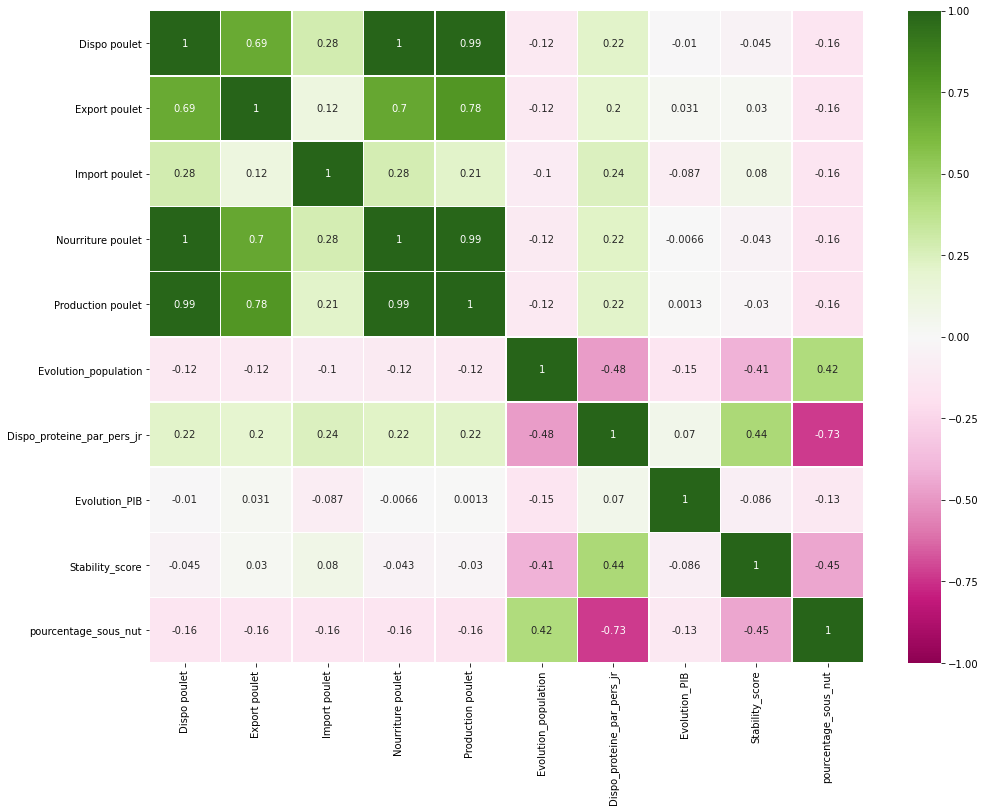

In [77]:
corr_df = df_general.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_df,cmap="PiYG", annot=True,vmin=-1, vmax=1,linewidths=.5)
plt.show()

In [78]:
### On voit que 4 variables très correlées (environ 1) qui apporte une redondance d'information

# Nourriture poulet, dispo poulet et production poulet très corrélées 

df_general.drop(columns=['Nourriture poulet','Production poulet'],inplace=True)

In [79]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 171
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Zone                        169 non-null    object 
 1   Dispo poulet                167 non-null    float64
 2   Export poulet               132 non-null    float64
 3   Import poulet               167 non-null    float64
 4   Evolution_population        169 non-null    float64
 5   Dispo_proteine_par_pers_jr  169 non-null    float64
 6   Evolution_PIB               157 non-null    float64
 7   Stability_score             166 non-null    float64
 8   pourcentage_sous_nut        155 non-null    float64
dtypes: float64(8), object(1)
memory usage: 13.2+ KB


In [80]:
df_general.describe()

,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut
count,1.670000e+02,1.320000e+02,1.670000e+02,169.000000,169.000000,157.000000,166.000000,155.000000
mean,6.934551e+05,1.301061e+05,8.460479e+04,7.055179,80.717278,-2.071300,-0.083855,9.069032
std,2.206002e+06,5.173136e+05,1.771100e+05,6.589585,19.839917,9.134838,0.895256,10.589951
min,2.000000e+03,0.000000e+00,0.000000e+00,-7.030485,39.910000,-27.740799,-2.940000,1.250000
25%,3.100000e+04,0.000000e+00,3.000000e+03,2.384357,64.040000,-7.045150,-0.637500,1.250000
50%,9.800000e+04,2.500000e+03,1.600000e+04,6.149831,81.150000,-1.822666,-0.040000,5.600000
75%,3.645000e+05,3.050000e+04,7.850000e+04,11.557978,95.460000,3.159380,0.637500,11.850000
max,1.826600e+07,4.223000e+06,1.069000e+06,33.387345,141.340000,55.596648,1.590000,48.000000


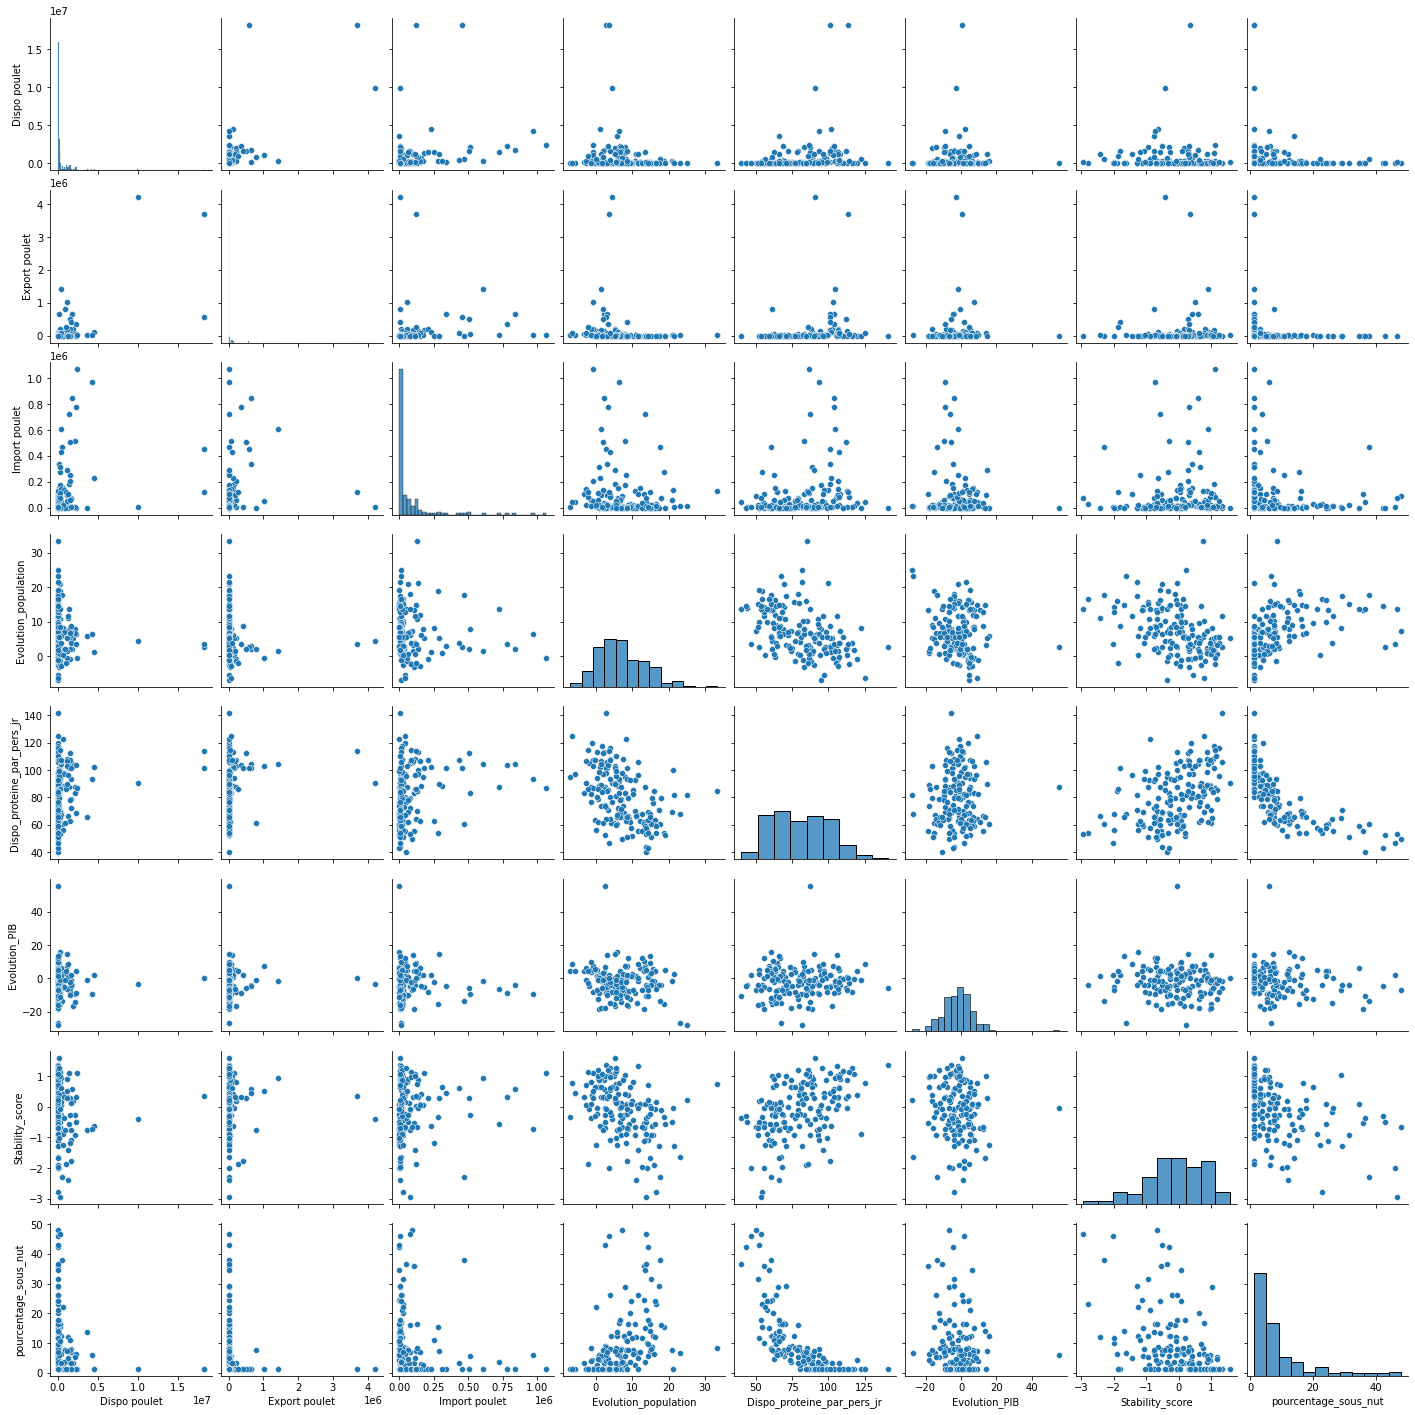

In [81]:
# visualisation de correlations (il n'en reste plus, car élimination après heatmap) et des allures des distributions
sns.pairplot(df_general, diag_kind='hist')

<AxesSubplot:>

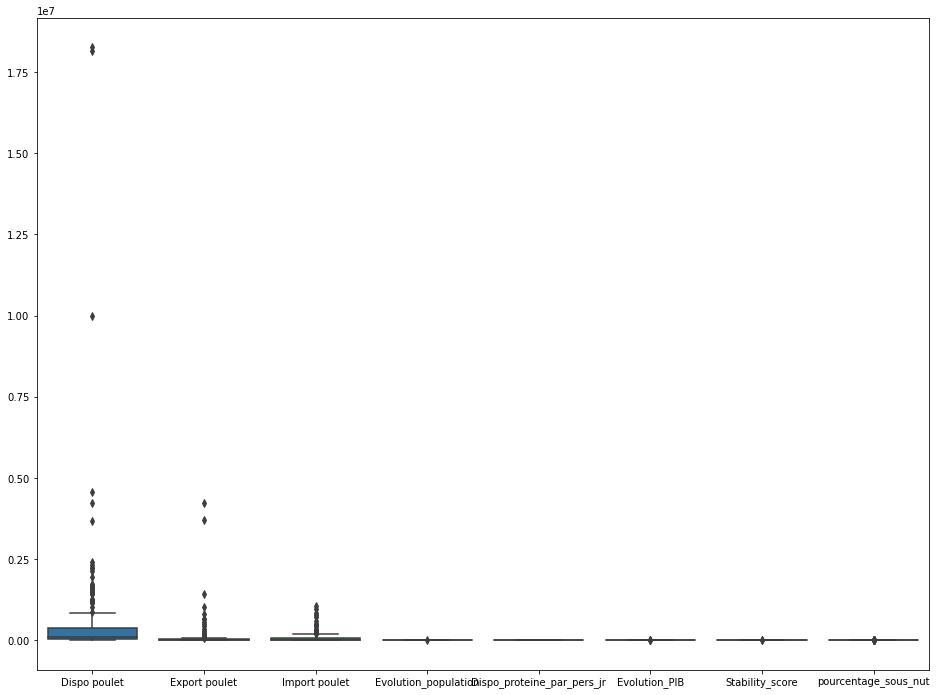

In [82]:
# Outliers dispo poulet et export poulet
plt.figure(figsize=(16, 12))
sns.boxplot(data=df_general)

<AxesSubplot:xlabel='Dispo poulet'>

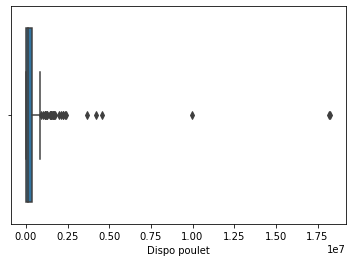

In [83]:
# outliers marqués dans dispo poulet
sns.boxplot(x="Dispo poulet",data=df_general)

<AxesSubplot:xlabel='Export poulet'>

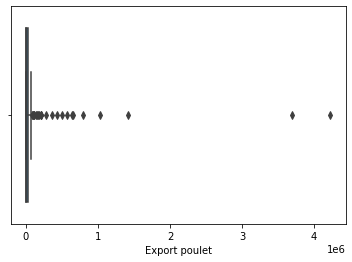

In [84]:
sns.boxplot(x='Export poulet',data=df_general)

<AxesSubplot:xlabel='Import poulet'>

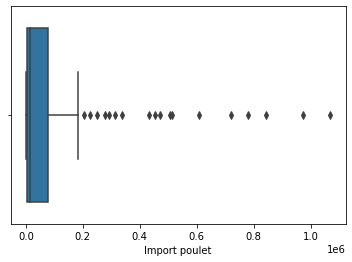

In [85]:
sns.boxplot(x='Import poulet',data=df_general)

<AxesSubplot:xlabel='Evolution_population'>

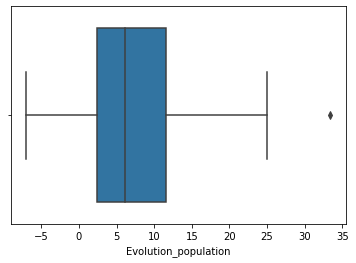

In [86]:
sns.boxplot(x='Evolution_population',data=df_general)

<AxesSubplot:xlabel='Dispo_proteine_par_pers_jr'>

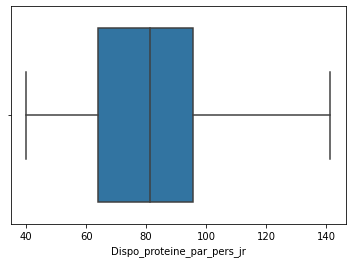

In [87]:
sns.boxplot(x='Dispo_proteine_par_pers_jr',data=df_general)

<AxesSubplot:xlabel='Evolution_PIB'>

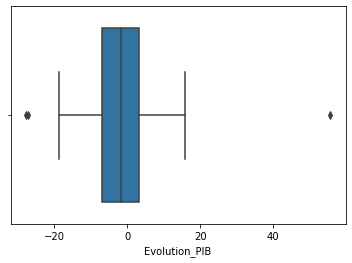

In [88]:
sns.boxplot(x='Evolution_PIB',data=df_general)

<AxesSubplot:xlabel='Stability_score'>

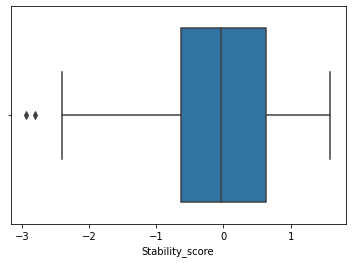

In [89]:
sns.boxplot(x='Stability_score',data=df_general)

<AxesSubplot:xlabel='pourcentage_sous_nut'>

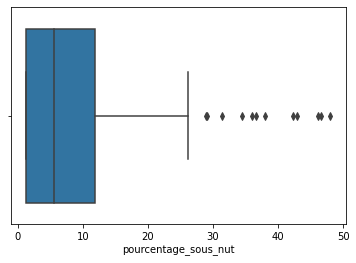

In [90]:
sns.boxplot(x='pourcentage_sous_nut',data=df_general)

In [91]:
df_general[df_general['pourcentage_sous_nut'].isna()].head(50)

,Zone,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut
6,Antigua-et-Barbuda,7000.0,0.0,7000.0,5.549226,81.15,-9.495824,0.75,NaN
13,Bahamas,26000.0,NaN,24000.0,4.997745,61.37,-15.246678,0.99,NaN
56,Grenade,8000.0,NaN,7000.0,3.190440,70.57,-7.100971,1.01,NaN
59,Guinée,50000.0,NaN,37000.0,13.288433,61.78,10.464058,-0.70,NaN
60,Guinée-Bissau,4000.0,NaN,4000.0,13.904606,44.13,-4.035944,-0.50,NaN
92,Maldives,12000.0,NaN,12000.0,24.963687,81.63,-27.740799,0.23,NaN
105,Niger,21000.0,0.0,3000.0,21.394364,81.86,2.852969,-1.27,NaN
112,Ouganda,66000.0,0.0,0.0,19.120752,52.32,4.959753,-0.57,NaN
128,République de Moldova,66000.0,0.0,16000.0,-0.395603,63.32,5.779613,-0.32,NaN
133,Saint-Kitts-et-Nevis,4000.0,0.0,4000.0,4.325776,76.86,-8.283485,0.65,NaN


In [92]:
# Conservation des données .csv
df_general.to_csv('/Users/anapereira/Desktop/Projets/projet 9/datap9.csv')

# Centrage et réduction

In [93]:
# df moyennes en lieu des NaN
data= df_general.fillna(df_general.mean())
data=data.set_index('Zone')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, Afghanistan to Îles Salomon
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Dispo poulet                169 non-null    float64
 1   Export poulet               169 non-null    float64
 2   Import poulet               169 non-null    float64
 3   Evolution_population        169 non-null    float64
 4   Dispo_proteine_par_pers_jr  169 non-null    float64
 5   Evolution_PIB               169 non-null    float64
 6   Stability_score             169 non-null    float64
 7   pourcentage_sous_nut        169 non-null    float64
dtypes: float64(8)
memory usage: 11.9+ KB


In [94]:
# préparation des données pour le clustering
X = data.values
names = data.index
features = data.columns
X = X.astype(np.float64)

In [95]:
# Importation librairie
from sklearn import preprocessing

In [96]:
# Centrage et réduction
# variables auront μ = 0 et σ = 1
std_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = std_scaler.transform(X)

In [97]:
#vérification de la standardisation
# moyenne de chaque colonne est égale à 0 et si l'écart type de chaque colonne est égale à 1
np.mean(X_scaled,axis=0)

array([ 2.10219744e-17, -1.51095441e-17,  6.30659233e-17,  1.10365366e-16,
       -2.20730732e-16,  1.05109872e-17,  4.72994425e-17,  5.25549361e-17])

In [98]:
np.std(X_scaled,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

# Partition des données avec clustering ascendant hierarchique

In [99]:
# Import librairies
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

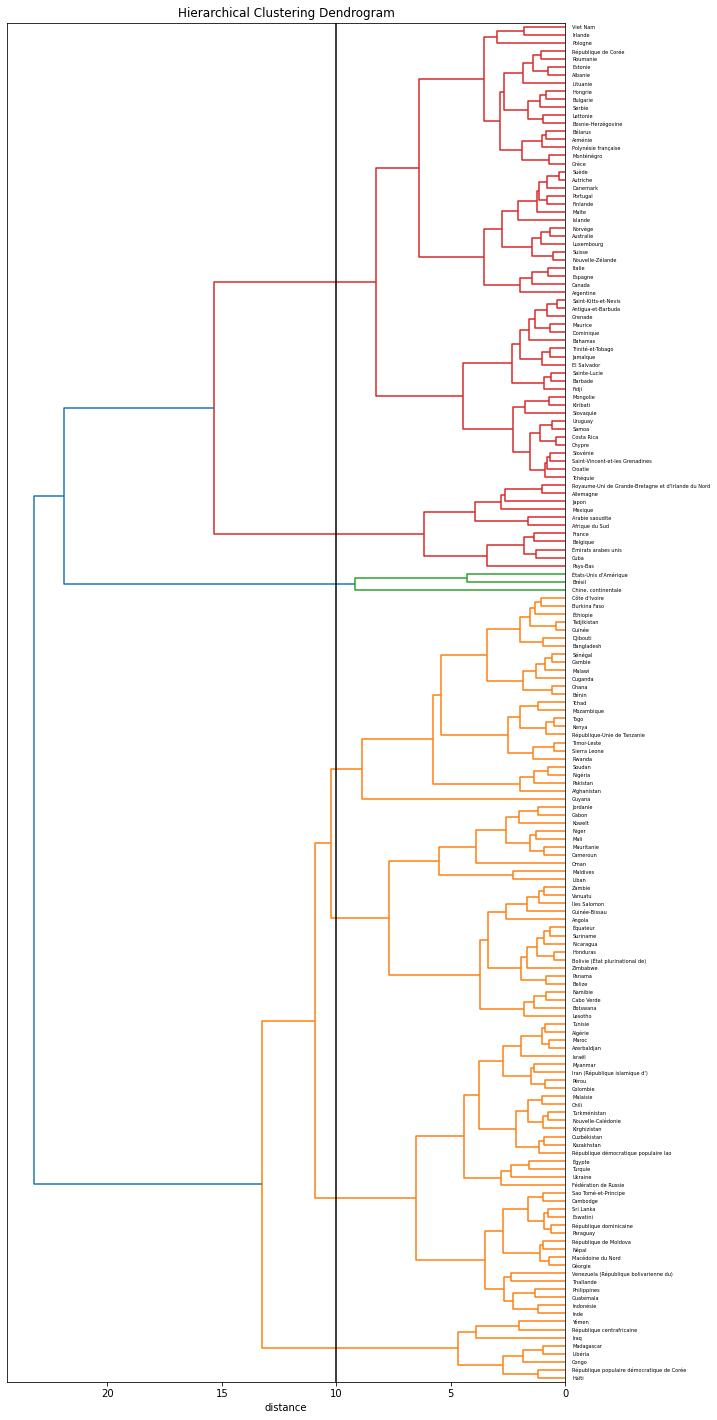

In [100]:
# Clustering hiérarchique ward
Z = linkage(X_scaled, 'ward')
# Affichage du dendrogramme
plot_dendrogram(Z, names)

In [101]:
# Coupage du dendrogramme en 7 clusters
clusters = fcluster(Z, 7, criterion='maxclust')

# les clusters trouvés
data_clusters_CAH = pd.DataFrame({"Zone": names, "cluster": clusters})
print(data_clusters_CAH)
print(data_clusters_CAH.pivot_table(index="Zone", columns="cluster", aggfunc=len, fill_value=0))

                      Zone  cluster
0              Afghanistan        4
1           Afrique du Sud        6
2                  Albanie        7
3                  Algérie        2
4                Allemagne        6
..                     ...      ...
164    Émirats arabes unis        6
165               Équateur        3
166  États-Unis d'Amérique        5
167               Éthiopie        4
168           Îles Salomon        3

[169 rows x 2 columns]
cluster                1  2  3  4  5  6  7
Zone                                      
Afghanistan            0  0  0  1  0  0  0
Afrique du Sud         0  0  0  0  0  1  0
Albanie                0  0  0  0  0  0  1
Algérie                0  1  0  0  0  0  0
Allemagne              0  0  0  0  0  1  0
...                   .. .. .. .. .. .. ..
Émirats arabes unis    0  0  0  0  0  1  0
Équateur               0  0  1  0  0  0  0
États-Unis d'Amérique  0  0  0  0  1  0  0
Éthiopie               0  0  0  1  0  0  0
Îles Salomon           0  0 

In [102]:
# Nombre de pays par cluster
data_clusters_CAH.groupby(['cluster'])['Zone'].nunique()

cluster
1     8
2    37
3    27
4    26
5     3
6    11
7    57
Name: Zone, dtype: int64

In [103]:
# nouveau df avec colonne clusters
data_with_clusters_CAH = data.copy()
data_with_clusters_CAH['clusters'] = clusters
data_with_clusters_CAH

,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut,clusters
Zone,,,,,,,,,
Afghanistan,57000.0,1.301061e+05,29000.0,16.477889,54.09,-3.857365,-2.80,23.00,4
Afrique du Sud,2118000.0,6.300000e+04,514000.0,7.906280,83.36,-9.724201,-0.28,5.50,6
Albanie,47000.0,0.000000e+00,38000.0,-1.026974,119.50,4.106178,0.38,4.10,7
Algérie,277000.0,0.000000e+00,2000.0,10.713956,92.85,-8.994326,-0.92,2.70,2
Allemagne,1739000.0,6.460000e+05,842000.0,2.081915,104.07,-3.834540,0.59,1.25,6
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,412000.0,9.400000e+04,433000.0,3.780598,107.26,-2.071300,0.62,3.20,6
Équateur,341000.0,0.000000e+00,0.0,8.473901,65.77,-11.092366,-0.07,10.70,3
États-Unis d'Amérique,18266000.0,3.692000e+06,123000.0,3.515710,113.61,0.209617,0.34,1.25,5


In [104]:
data_with_clusters_CAH[data_with_clusters_CAH['clusters']==6]

,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut,clusters
Zone,,,,,,,,,
Afrique du Sud,2118000.0,6.300000e+04,514000.0,7.906280,83.36,-9.724201,-0.28,5.50,6
Allemagne,1739000.0,6.460000e+05,842000.0,2.081915,104.07,-3.834540,0.59,1.25,6
Arabie saoudite,1435000.0,1.000000e+04,722000.0,13.535560,87.51,-6.295158,-0.58,3.70,6
Belgique,152000.0,6.560000e+05,338000.0,3.016502,101.35,-4.425452,0.43,1.25,6
Cuba,342000.0,1.301061e+05,312000.0,0.729761,88.40,-2.071300,0.65,1.25,6
France,1573000.0,5.010000e+05,506000.0,2.011018,112.08,-5.723791,0.28,1.25,6
Japon,2415000.0,1.000000e+04,1069000.0,-0.717038,86.52,-2.071300,1.11,1.25,6
Mexique,4219000.0,9.000000e+03,972000.0,6.397973,93.30,-9.297054,-0.72,6.10,6
Pays-Bas,372000.0,1.418000e+06,608000.0,1.366777,104.43,-1.595611,0.92,1.25,6


In [105]:
data_with_clusters_CAH[data_with_clusters_CAH['clusters']==7]

,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut,clusters
Zone,,,,,,,,,
Albanie,47000.0,0.000000e+00,38000.0,-1.026974,119.50,4.106178,0.380000,4.100000,7
Antigua-et-Barbuda,7000.0,0.000000e+00,7000.0,5.549226,81.15,-9.495824,0.750000,9.069032,7
Argentine,1962000.0,2.070000e+05,8000.0,5.225563,102.66,-16.572375,0.170000,3.100000,7
Arménie,47000.0,0.000000e+00,35000.0,2.099587,97.33,3.941362,-0.620000,3.100000,7
Australie,1171000.0,4.200000e+04,16000.0,7.337914,108.01,0.443871,0.890000,1.250000,7
Autriche,173000.0,7.800000e+04,110000.0,3.736362,108.11,-4.124792,1.050000,1.250000,7
Bahamas,26000.0,1.301061e+05,24000.0,4.997745,61.37,-15.246678,0.990000,9.069032,7
Barbade,17000.0,0.000000e+00,2000.0,0.892136,88.74,-18.487555,0.970000,4.300000,7
Bosnie-Herzégovine,55000.0,8.000000e+03,10000.0,-7.030485,94.58,4.260641,-0.350000,1.250000,7


In [106]:
data_with_clusters_CAH[data_with_clusters_CAH['clusters']==5]

,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut,clusters
Zone,,,,,,,,,
Brésil,9982000.0,4223000.0,3000.0,4.288544,90.87,-3.171172,-0.420000,1.25,5
"Chine, continentale",18161000.0,576000.0,452000.0,2.659675,101.44,-2.071300,-0.083855,1.25,5
États-Unis d'Amérique,18266000.0,3692000.0,123000.0,3.515710,113.61,0.209617,0.340000,1.25,5


In [107]:
data_with_clusters_CAH.to_csv('/Users/anapereira/Desktop/Projets/projet 9/CAH.csv')

## heatmap des clusters et des variables

In [108]:
# means des data par clusters du CAH 
means_CAH =  data_with_clusters_CAH.groupby(by="clusters").mean()

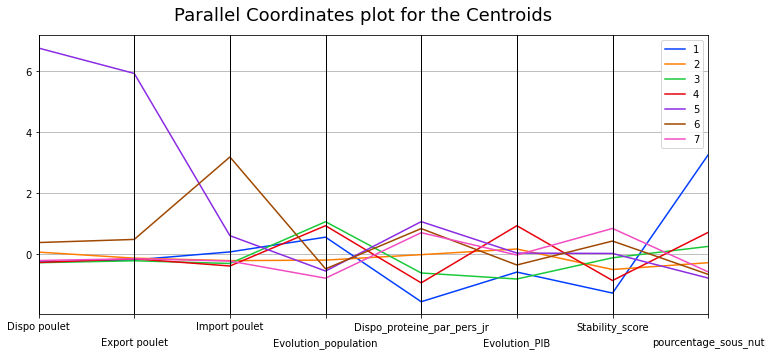

In [109]:
# Visualisation des moyennes des variables pour les différents clusters obtenus par CAH

X_clustered = pd.DataFrame(X_scaled, index=names, columns=features)
X_clustered["cluster"] = clusters
means =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(means.reset_index(), 7)

In [110]:
#check pour range heatmap
CAH_heatmap=pd.DataFrame(X_scaled, index=clusters, columns = features).groupby(clusters).mean()
CAH_heatmap

,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut
1,-0.248226,-0.178538,0.082722,0.566244,-1.547549,-0.577189,-1.264580,3.262515
2,0.076607,-0.120888,-0.202038,-0.185255,-0.005915,0.178357,-0.492855,-0.270389
3,-0.269846,-0.207210,-0.296103,1.072227,-0.606745,-0.804264,-0.109106,0.263172
4,-0.262555,-0.142493,-0.377476,0.941204,-0.930353,0.940786,-0.853050,0.724073
5,6.758440,5.928627,0.615629,-0.542948,1.074562,0.044857,0.033051,-0.773467
6,0.390150,0.492003,3.192572,-0.471627,0.846812,-0.345207,0.439071,-0.652064
7,-0.198305,-0.140303,-0.216533,-0.776846,0.712841,-0.018671,0.851728,-0.570774


Text(0.5, 1.0, 'heatmap des 7 clusters du CAH et des variables')

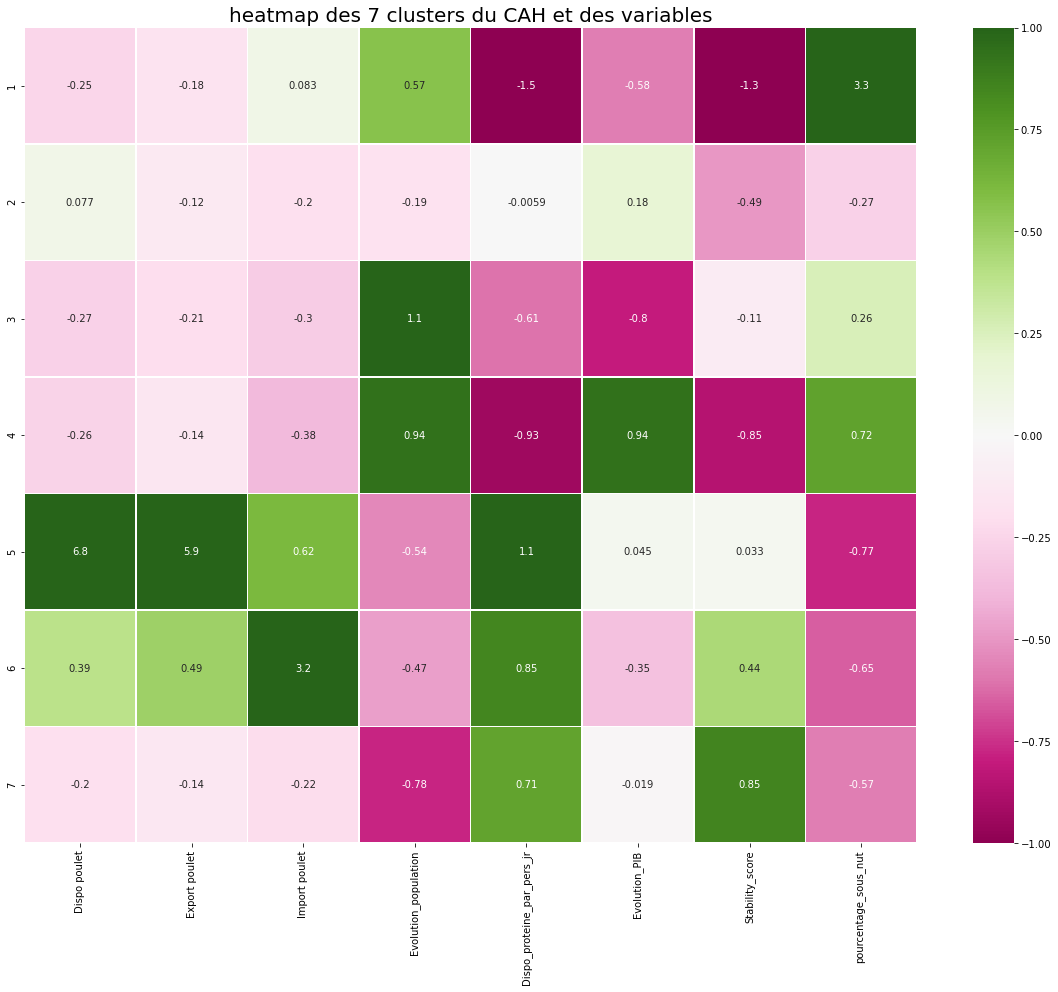

In [111]:
#Viz heatmap
plt.figure(figsize=(20,15))
sns.heatmap(CAH_heatmap,cmap="PiYG", annot=True, vmin=-1, vmax=1,linewidths=.5)
plt.title("heatmap des 7 clusters du CAH et des variables", fontsize =20)

# cluster 6 le plus interessant ici (bonne stabilité politique et import poulet fort. 
# cluster 7 evolution PIB moindre ainsi que l import poulet

In [112]:
# cluster 1 forte sous nutrition et instabilité politique : pays pauvres
# clusters 5 6 et 7 pays avec bonne stabilité politique
# cluster 5 saturation en dispo poulet ? forte concurrence ? gros export
# cluster 6 gros importateur de poulet : cluster très interessant
# clusters 3 et 4 forte evolution positive de la population, mais attention
# cluster 4 voir l'instabilité politique et la forte sous nutrition
# cluster 6 semble ici le plus propice pour importer La Poule qui chante
print('liste des pays du cluster 6 : \n',data_with_clusters_CAH.index[data_with_clusters_CAH['clusters']==6])

liste des pays du cluster 6 : 
 Index(['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Belgique', 'Cuba',
       'France', 'Japon', 'Mexique', 'Pays-Bas',
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord',
       'Émirats arabes unis'],
      dtype='object', name='Zone')


## Tests des autres méthodes de CAH

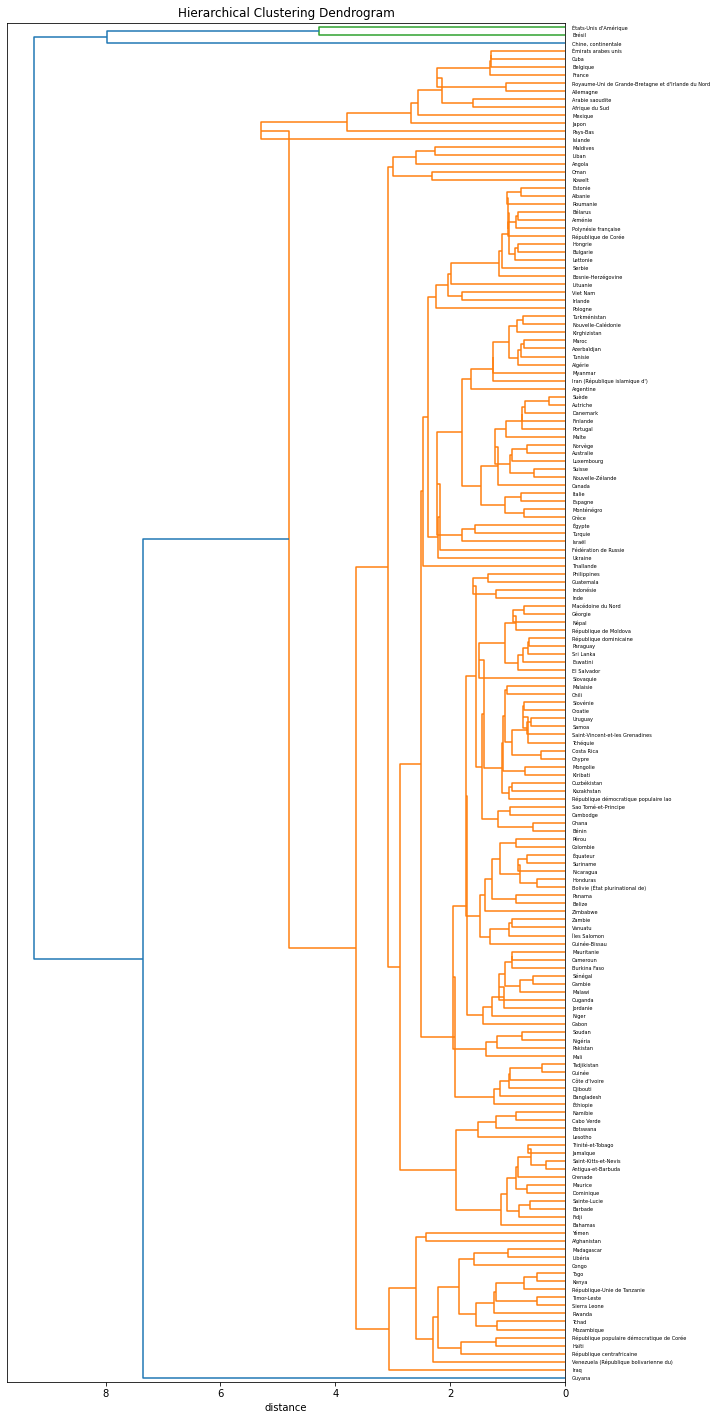

In [113]:
# Autres méthodes comparaison CAH
# Clustering hiérarchique median
Z_median = linkage(X_scaled, 'median')
# Affichage du dendrogramme
plot_dendrogram(Z_median, names)

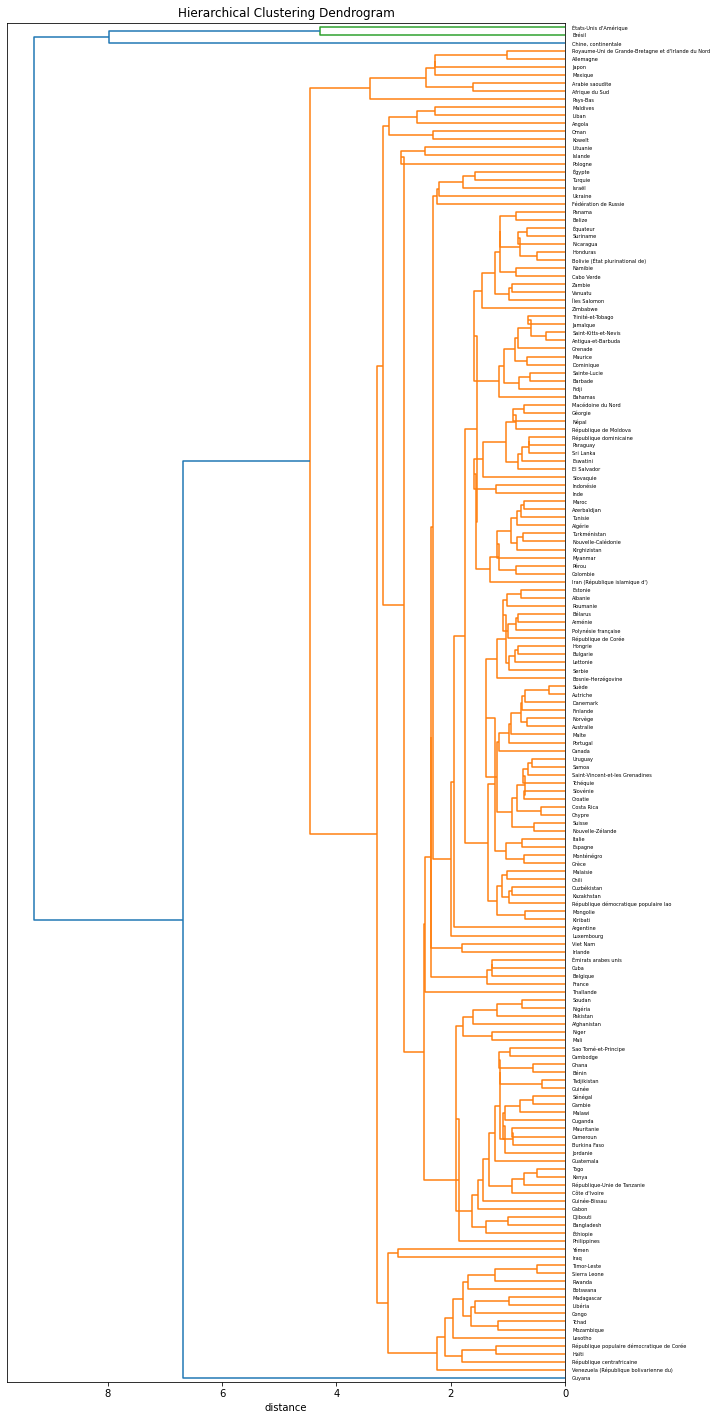

In [114]:
# Autre méthode Comparaison Clustering hiérarchique centroid
Z_centroid = linkage(X_scaled, 'centroid')
# Affichage du dendrogramme
plot_dendrogram(Z_centroid, names)

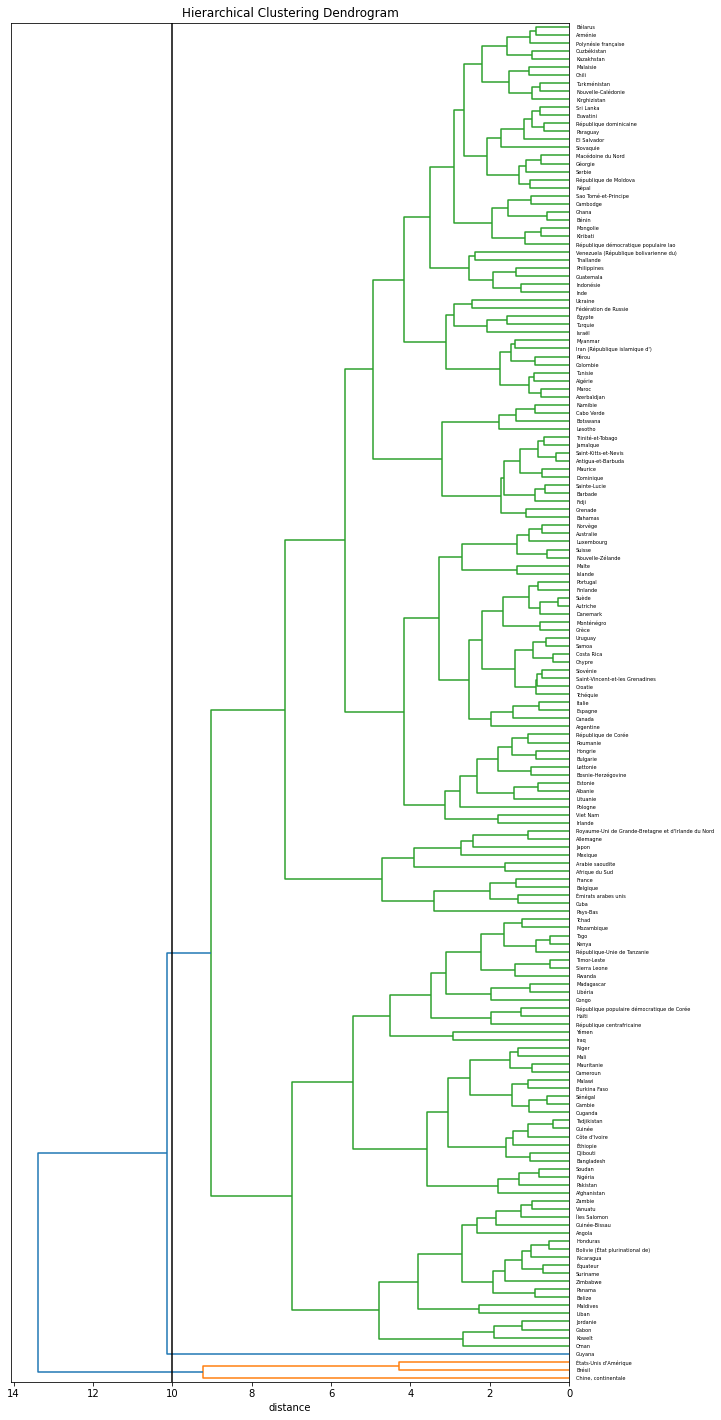

In [115]:
# Autre méthode Comparaison Clustering hiérarchique complete
Z_complete = linkage(X_scaled, 'complete')
# Affichage du dendrogramme
plot_dendrogram(Z_complete, names)

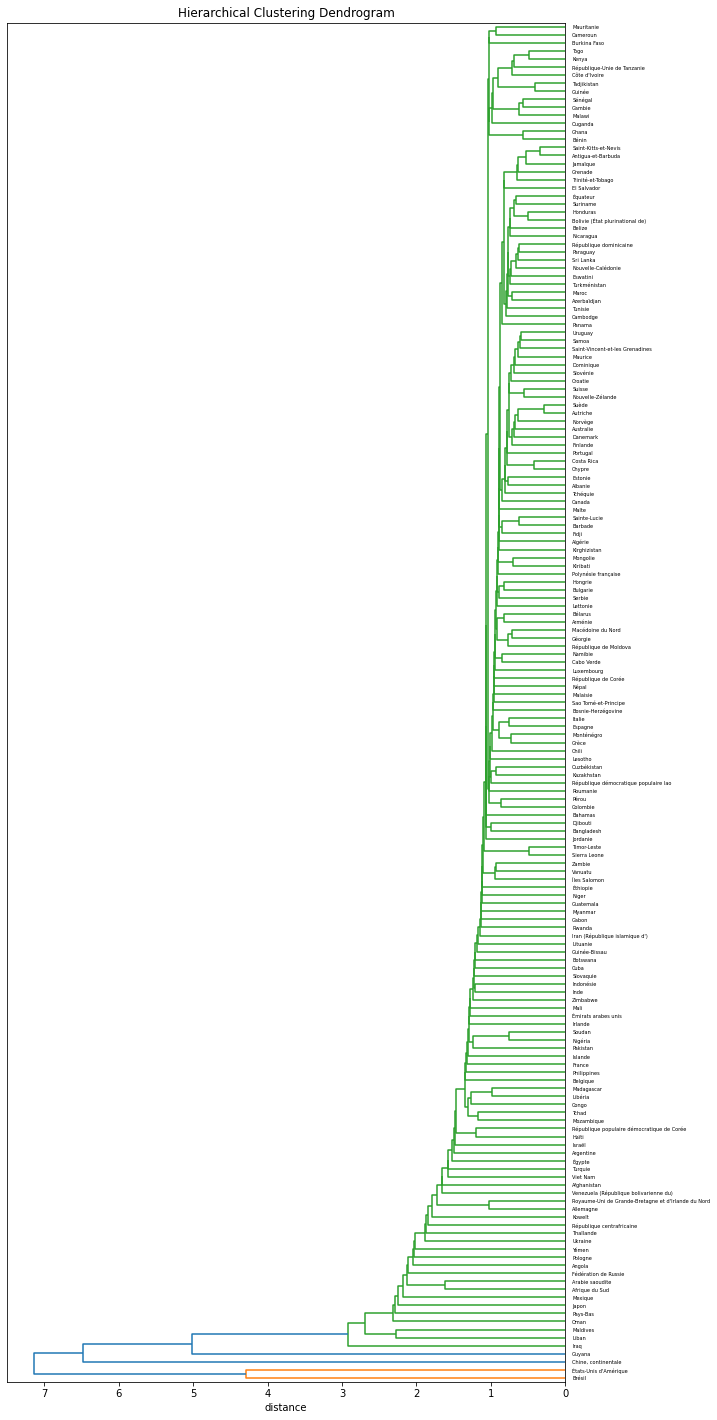

In [116]:
# Autre méthode Comparaison Clustering hiérarchique single
Z_single = linkage(X_scaled, 'single')
# Affichage du dendrogramme
plot_dendrogram(Z_single, names)

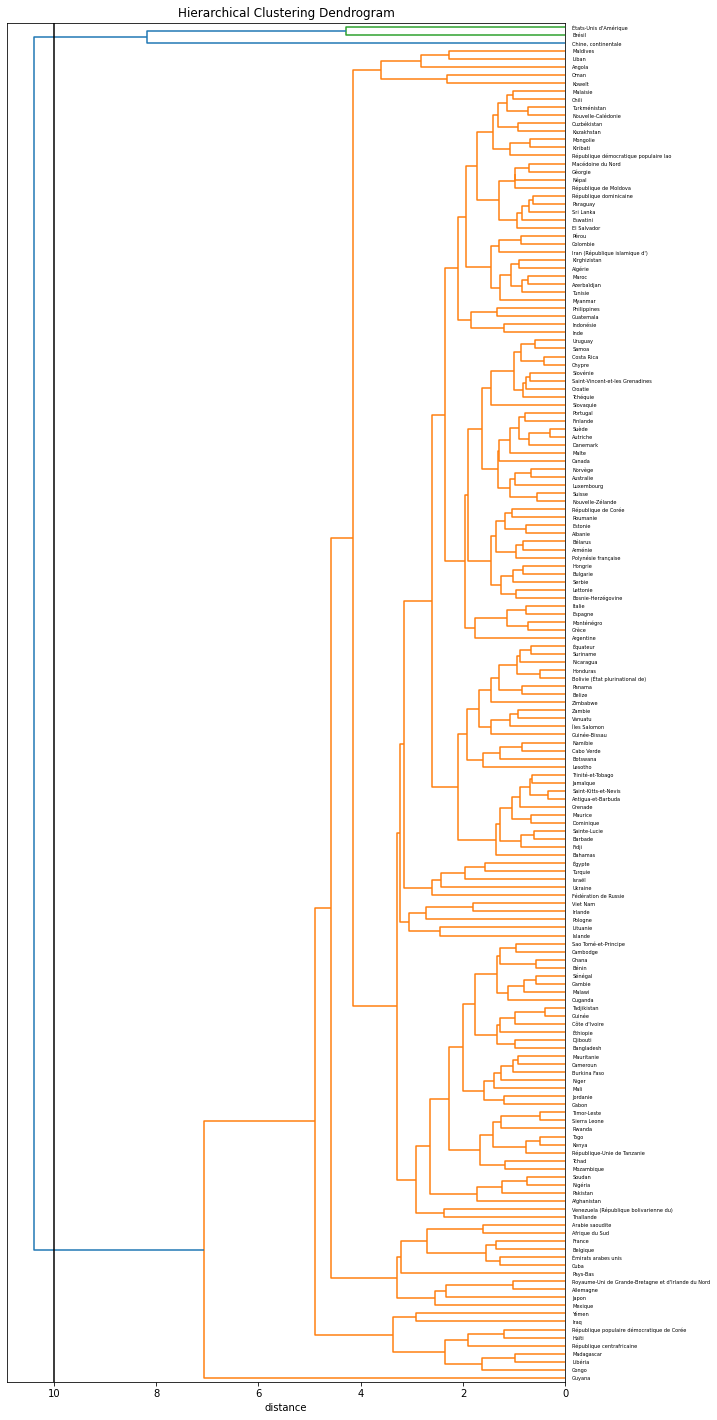

In [117]:
# Autre méthode Comparaison Clustering hiérarchique average
Z_average = linkage(X_scaled, 'average')
# Affichage du dendrogramme
plot_dendrogram(Z_average, names)

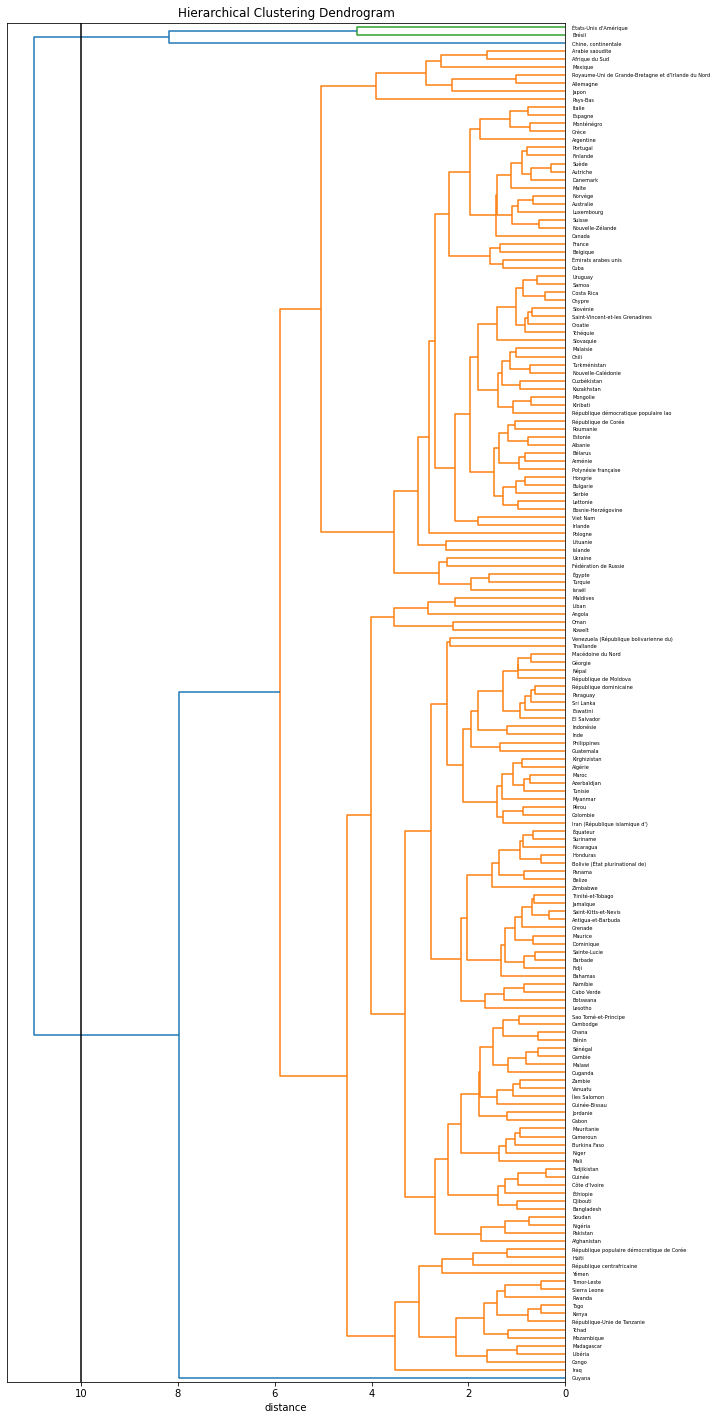

In [118]:
# Autre méthode Comparaison Clustering hiérarchique weighted
Z_weighted = linkage(X_scaled, 'weighted')
# Affichage du dendrogramme
plot_dendrogram(Z_weighted, names)

In [119]:
# La méthode de CAH la plus appropriée ici est la méthode Ward

# KMeans

## Déterminer le nombre de clusters souhaités

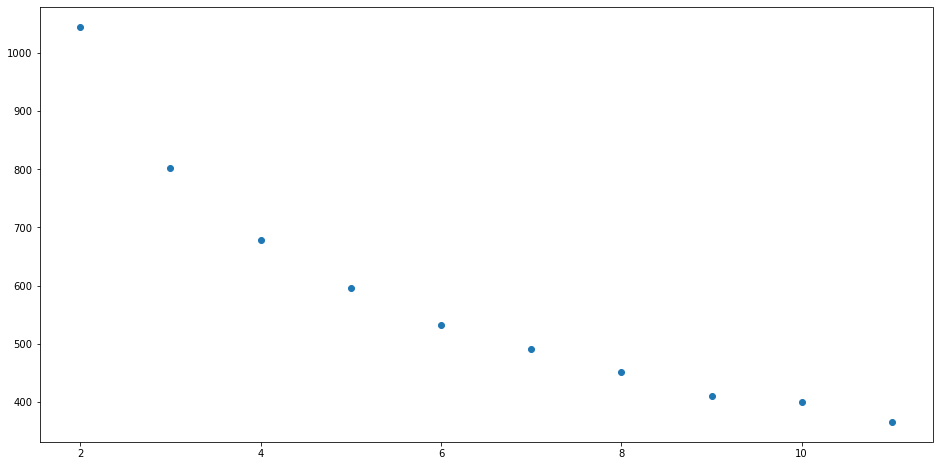

In [120]:
# Méthode du coude
# tracé de la courbe d'inertie pour déterminer le nombre de clusters
# la décroissance de l’inertie intra-classe pour déterminer la “meilleure” valeur de k. 
# nous cherchons alors à identifier les étapes où l’on observe une rupture dans la décroissance de cette courbe.
from sklearn import cluster
a=[]
for i in range(2,12):
    kmeans = cluster.KMeans(n_clusters=i) 
    kmeans.fit(X_scaled) 
    a.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.scatter(range(2,12),a)

In [121]:
## Ici, Une légère cassure de la courbe à k=5
# Comment determiner le nombre de k possibles sur un plot ?????  change la visibilité de la courbure

Populating the interactive namespace from numpy and matplotlib


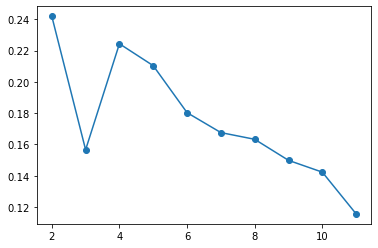

In [122]:
# Méthode du coefficient de silhouette KMeans
# calcul du coefficient de silhouette kmeans pour choisir le nombre de clusters le plus approprié

%pylab inline
from sklearn import metrics
silhouettes = []
for num_clusters in range (2,12):
    cls = cluster.KMeans(n_clusters=num_clusters,
                        n_init=1, init='random',random_state=2)
    cls.fit(X_scaled)
    silh=metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
plt.plot(range(2,12),silhouettes, marker='o')

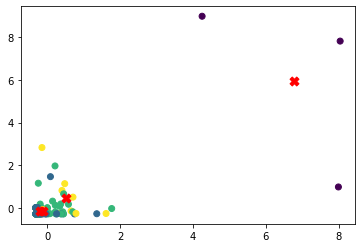

In [123]:
# scatter des Kmeans

cls4=cluster.KMeans(n_clusters=4,random_state=4,max_iter=100)
cls4.fit(X_scaled)

plt.scatter(X_scaled[:,0],X_scaled[:,1], c=cls4.labels_)

# creation des centroides
centroids = cls4.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1],marker="X", c="r", s=80, label="centroids")

In [124]:
# les clusters via kmeans
cls4.labels_

array([1, 3, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0,
       2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2,
       1, 2, 2, 2, 2, 2, 3, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1,
       2, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 0, 1, 1], dtype=int32)

## Heatmap des clusters du KMeans et des variables

In [125]:
# df with clusters kmeans X_scaled
data_KM=X_scaled

In [126]:
# nouveau df avec colonne clusters
data_with_clusters_KM = data.copy()
data_with_clusters_KM['clusters_KM'] = cls4.labels_
data_with_clusters_KM

,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut,clusters_KM
Zone,,,,,,,,,
Afghanistan,57000.0,1.301061e+05,29000.0,16.477889,54.09,-3.857365,-2.80,23.00,1
Afrique du Sud,2118000.0,6.300000e+04,514000.0,7.906280,83.36,-9.724201,-0.28,5.50,3
Albanie,47000.0,0.000000e+00,38000.0,-1.026974,119.50,4.106178,0.38,4.10,2
Algérie,277000.0,0.000000e+00,2000.0,10.713956,92.85,-8.994326,-0.92,2.70,2
Allemagne,1739000.0,6.460000e+05,842000.0,2.081915,104.07,-3.834540,0.59,1.25,3
...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,412000.0,9.400000e+04,433000.0,3.780598,107.26,-2.071300,0.62,3.20,3
Équateur,341000.0,0.000000e+00,0.0,8.473901,65.77,-11.092366,-0.07,10.70,1
États-Unis d'Amérique,18266000.0,3.692000e+06,123000.0,3.515710,113.61,0.209617,0.34,1.25,0


In [127]:
data_with_clusters_KM['clusters_KM'].unique()

array([1, 3, 2, 0], dtype=int32)

In [128]:
KMM=data_with_clusters_KM.reset_index()
KMM.groupby(['clusters_KM'])['Zone'].nunique()

clusters_KM
0     3
1    71
2    86
3     9
Name: Zone, dtype: int64

In [129]:
# On voit deux gros clusters, trois outliers et 9 Zones se démarquent (clusters 3)
KMM[KMM['clusters_KM']==3]

,Zone,Dispo poulet,Export poulet,Import poulet,Evolution_population,Dispo_proteine_par_pers_jr,Evolution_PIB,Stability_score,pourcentage_sous_nut,clusters_KM
1,Afrique du Sud,2118000.0,63000.0,514000.0,7.906280,83.36,-9.724201,-0.28,5.50,3
4,Allemagne,1739000.0,646000.0,842000.0,2.081915,104.07,-3.834540,0.59,1.25,3
7,Arabie saoudite,1435000.0,10000.0,722000.0,13.535560,87.51,-6.295158,-0.58,3.70,3
48,France,1573000.0,501000.0,506000.0,2.011018,112.08,-5.723791,0.28,1.25,3
72,Japon,2415000.0,10000.0,1069000.0,-0.717038,86.52,-2.071300,1.11,1.25,3
95,Mexique,4219000.0,9000.0,972000.0,6.397973,93.30,-9.297054,-0.72,6.10,3
114,Pays-Bas,372000.0,1418000.0,608000.0,1.366777,104.43,-1.595611,0.92,1.25,3
121,Royaume-Uni de Grande-Bretagne et d'Irlande du...,2234000.0,359000.0,779000.0,3.412845,103.87,-9.001261,0.33,1.25,3
164,Émirats arabes unis,412000.0,94000.0,433000.0,3.780598,107.26,-2.071300,0.62,3.20,3


In [130]:
print('liste des pays du cluster 3 avec la méthode KMeans : \n', KMM.Zone[KMM['clusters_KM']==3]) 

liste des pays du cluster 3 avec la méthode KMeans : 
 1                                         Afrique du Sud
4                                              Allemagne
7                                        Arabie saoudite
48                                                France
72                                                 Japon
95                                               Mexique
114                                             Pays-Bas
121    Royaume-Uni de Grande-Bretagne et d'Irlande du...
164                                  Émirats arabes unis
Name: Zone, dtype: object


In [131]:
KMM.to_csv('/Users/anapereira/Desktop/Projets/projet 9/KMM.csv')

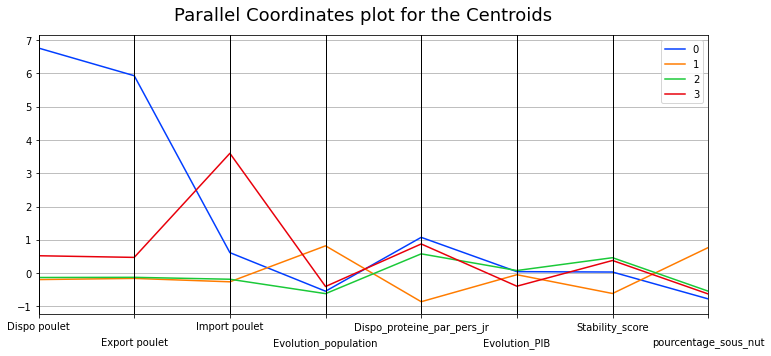

In [132]:
# Create a dataframe containing our centroids
centroids = pd.DataFrame(cls4.cluster_centers_, columns=features)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 10)

In [133]:
# df pour heatmap des data scaled avec clusters du Kmeans
KM = pd.DataFrame(X_scaled,columns=features)
KM['clusters_KM'] = cls4.labels_
KM_heatmap=KM.groupby('clusters_KM').mean()

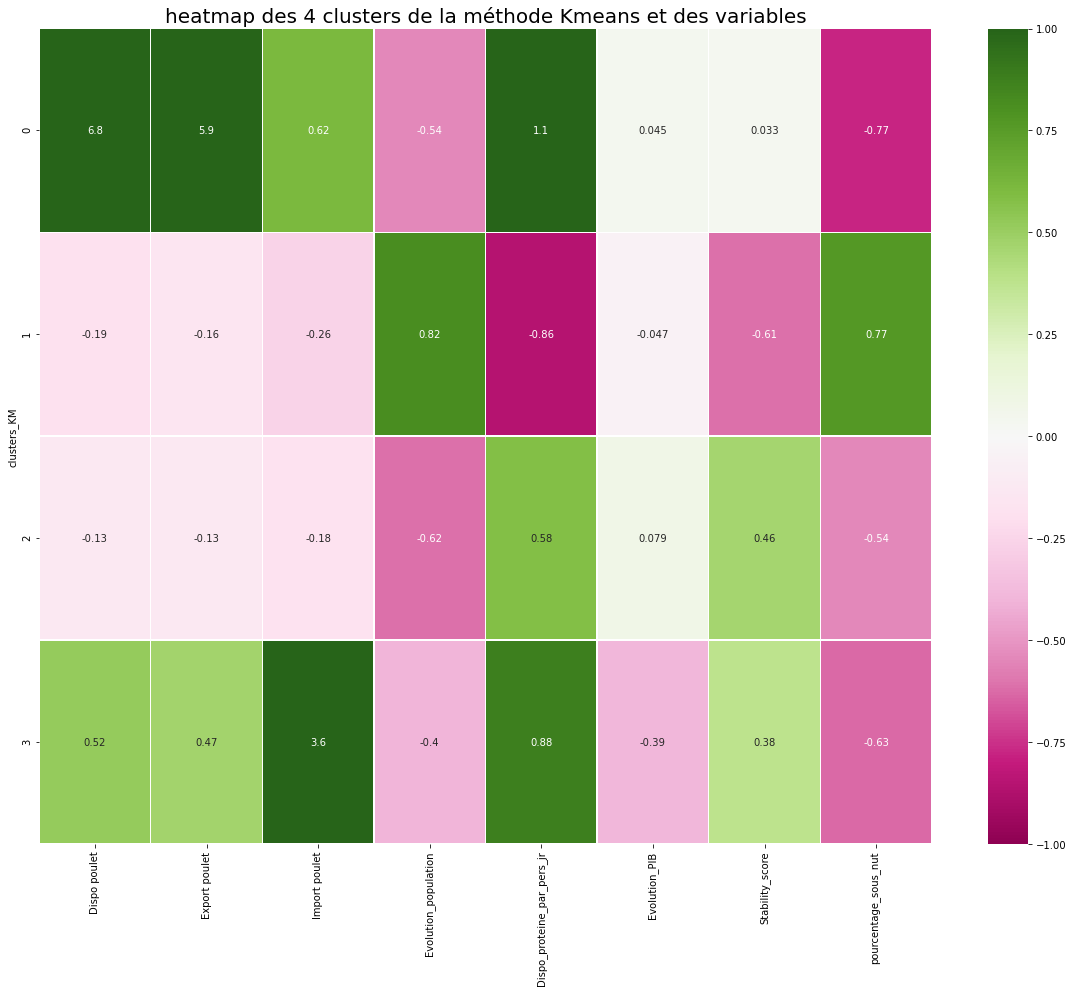

In [134]:
# visualisation des 4 clusters via Kmeans et variables
plt.figure(figsize=(20, 15))
sns.heatmap(KM_heatmap,cmap="PiYG",annot=True,linewidths=.5,vmin=-1, vmax=1)
plt.title("heatmap des 4 clusters de la méthode Kmeans et des variables", fontsize =20)
plt.show()

# ACP

## ACP sur data scaled

In [135]:
# Import librairie pour ACP

from sklearn import decomposition

# ACP 
# Create a PCA model to reduce our data to 2 dimensions for visualisation n components
# n_component par defaut est egal au nombre de variables ici 8
pca=decomposition.PCA(n_components=8)
pca.fit(X_scaled)

# Transfor the scaled data to the new PCA space
X_trans=pca.transform(X_scaled)


# Apport d'explication par ajout de variables
print (pca.explained_variance_ratio_.cumsum())

[0.33300383 0.53593157 0.67220186 0.78126982 0.86254431 0.92841373
 0.96501648 1.        ]


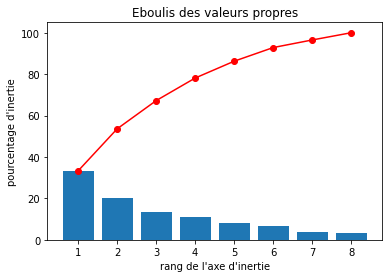

In [136]:
# Eboulis des valeurs propres : 
display_scree_plot(pca)

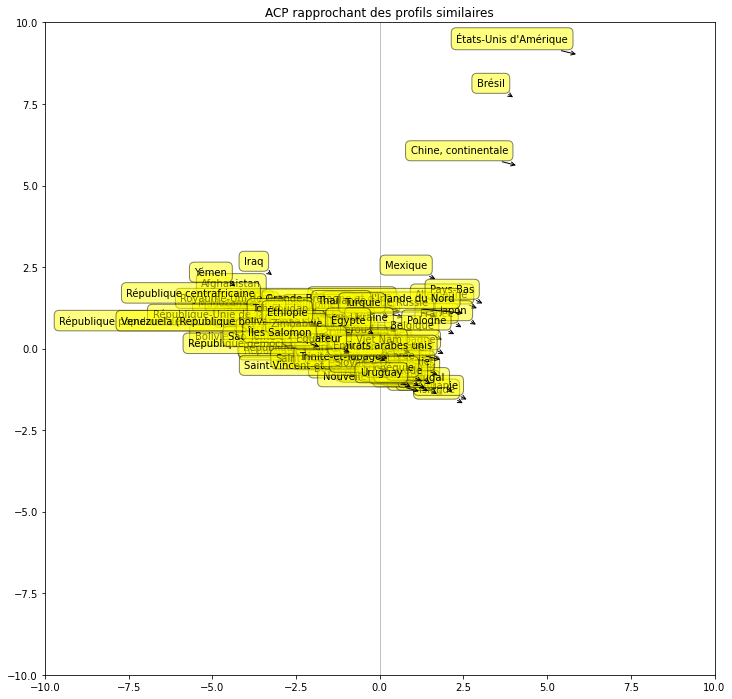

In [137]:
# Projections des zones

fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-10,10) #même limites en abscisse
axes.set_ylim(-10,10) #et en ordonnée

#ajouter les axes
plt.plot([10,10],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-10,10],color='silver',linestyle='-',linewidth=1)

#placement des étiquettes des observations
for label, x, y in zip(names, X_trans[:, 0], X_trans[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.title("ACP rapprochant des profils similaires")
#affichage
plt.show()

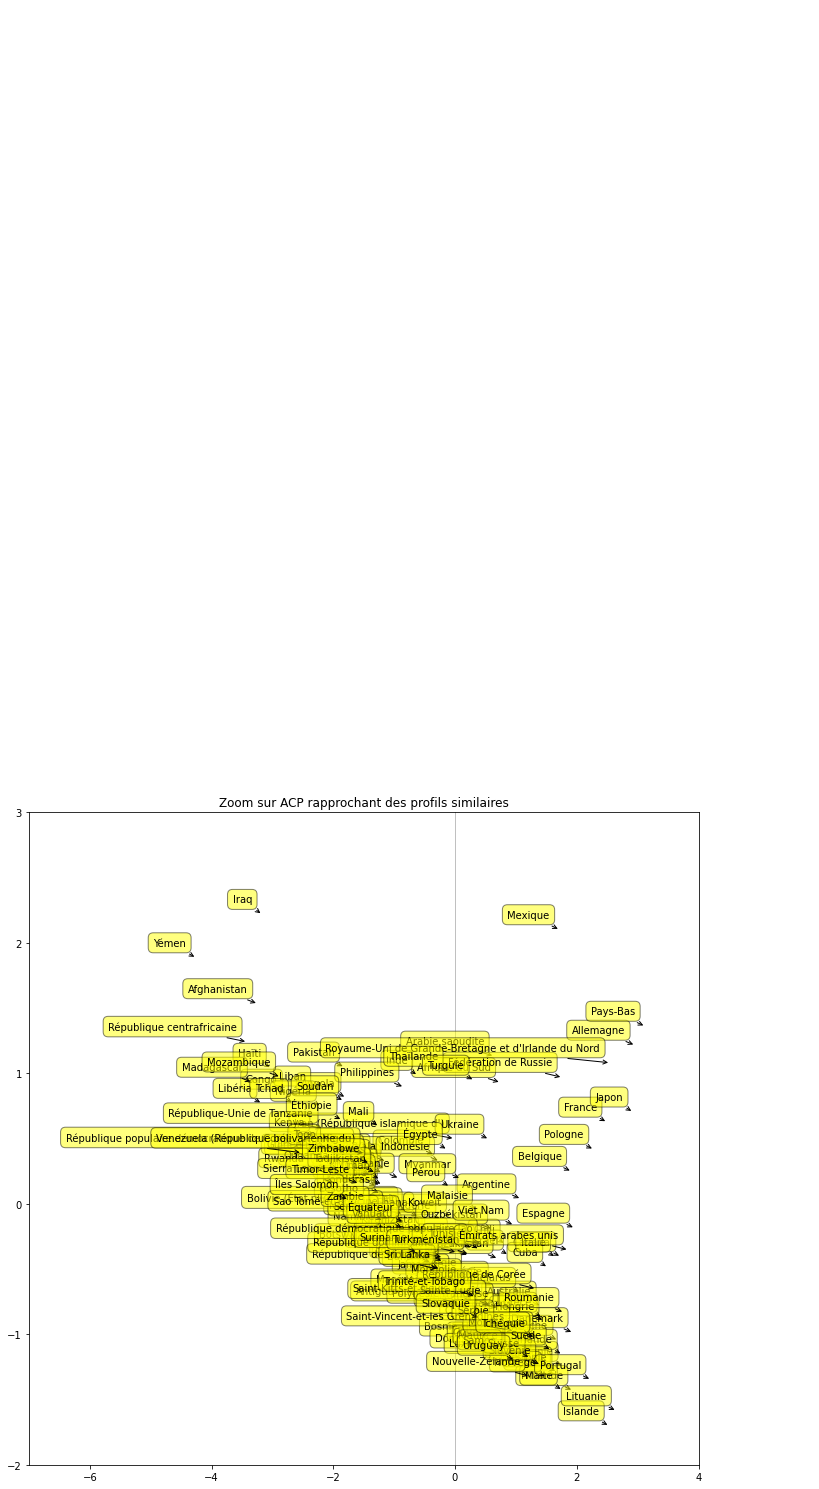

In [138]:
# ZOOM Projections des zones
# positionnement des individus dans le premier plan

fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-7,4)
axes.set_ylim(-2,3)
#ajouter les axes
plt.plot([10,10],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-10,10],color='silver',linestyle='-',linewidth=1)
#placement des étiquettes des observations
for label, x, y in zip(names, X_trans[:, 0], X_trans[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.title("Zoom sur ACP rapprochant des profils similaires")
#affichage
plt.show()

In [139]:
pca.components_

array([[ 0.27731543,  0.25542272,  0.22579987, -0.40875731,  0.51684771,
         0.06077189,  0.36775079, -0.48344788],
       [ 0.62498877,  0.58870552,  0.22262349,  0.20162996, -0.1408043 ,
        -0.05690283, -0.33762826,  0.18852683],
       [ 0.03084994,  0.13580534, -0.4030408 , -0.15309481, -0.01301114,
         0.85934171, -0.23124064, -0.05114282],
       [-0.08621546, -0.34516365,  0.80111992,  0.07489339,  0.07127966,
         0.3681332 , -0.2915694 , -0.02027926],
       [-0.01632155, -0.03500211, -0.18767889,  0.71340034,  0.32465547,
        -0.0421183 , -0.22201025, -0.5457851 ],
       [-0.03730633,  0.17943777,  0.16464004,  0.47762775, -0.23466255,
         0.33426128,  0.7317747 ,  0.09425698],
       [ 0.70040018, -0.62017982, -0.1370034 , -0.00127243, -0.25191421,
         0.03406492,  0.14188706, -0.14591747],
       [ 0.17855477, -0.18043818, -0.11882152,  0.16169676,  0.69560338,
         0.06643528,  0.08583042,  0.63217979]])

In [140]:

pd.DataFrame({"Noms des variables" : features, 
              "Composante 1" : pca.components_[0], "Composante 2" : pca.components_[1],
              "Composante 3" : pca.components_[2], "Composante 4" : pca.components_[3],
              "Composante 5" : pca.components_[4], "Composante 6" : pca.components_[5],
              "Composante 7" : pca.components_[6], "Composante 8" : pca.components_[7]})

,Noms des variables,Composante 1,Composante 2,Composante 3,Composante 4,Composante 5,Composante 6,Composante 7,Composante 8
0,Dispo poulet,0.277315,0.624989,0.030850,-0.086215,-0.016322,-0.037306,0.700400,0.178555
1,Export poulet,0.255423,0.588706,0.135805,-0.345164,-0.035002,0.179438,-0.620180,-0.180438
2,Import poulet,0.225800,0.222623,-0.403041,0.801120,-0.187679,0.164640,-0.137003,-0.118822
3,Evolution_population,-0.408757,0.201630,-0.153095,0.074893,0.713400,0.477628,-0.001272,0.161697
4,Dispo_proteine_par_pers_jr,0.516848,-0.140804,-0.013011,0.071280,0.324655,-0.234663,-0.251914,0.695603
5,Evolution_PIB,0.060772,-0.056903,0.859342,0.368133,-0.042118,0.334261,0.034065,0.066435
6,Stability_score,0.367751,-0.337628,-0.231241,-0.291569,-0.222010,0.731775,0.141887,0.085830
7,pourcentage_sous_nut,-0.483448,0.188527,-0.051143,-0.020279,-0.545785,0.094257,-0.145917,0.632180


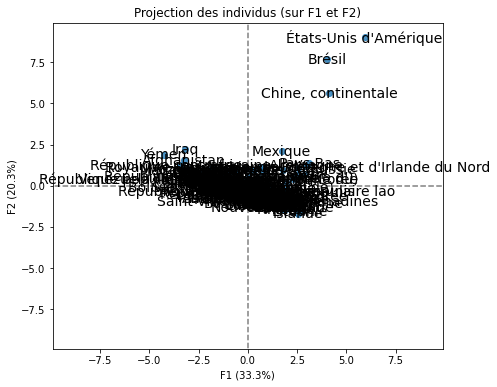

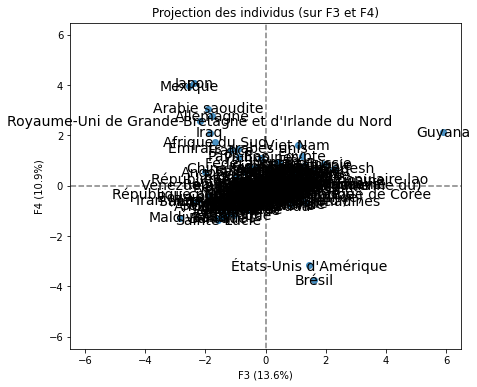

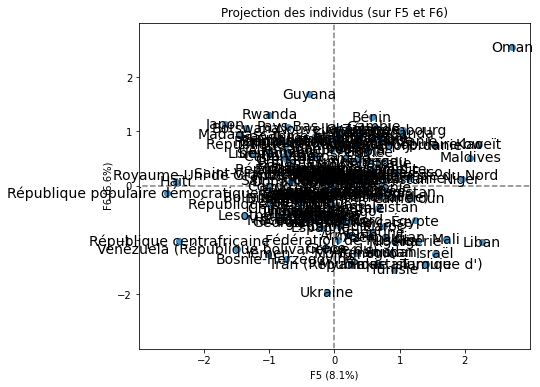

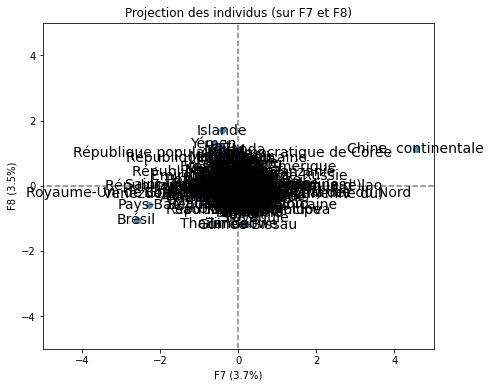

In [141]:
# display the data points in their clusters
display_factorial_planes(X_trans, 8, pca, [(0,1),(2,3),(4,5),(6,7)],labels=names, alpha = 0.8)

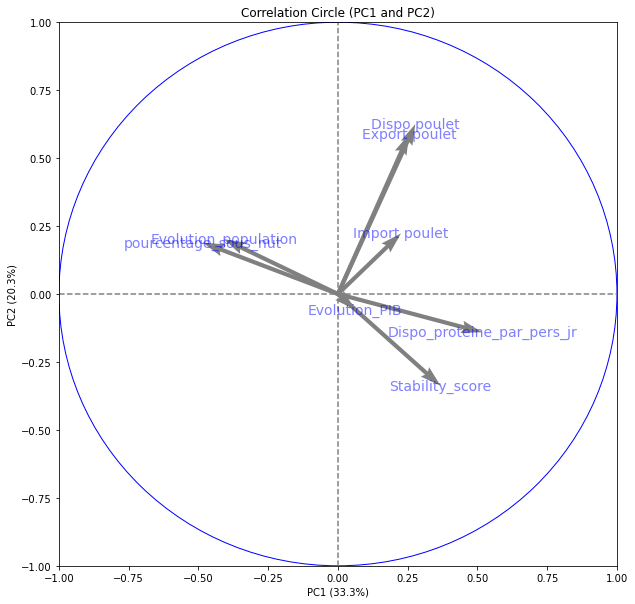

In [142]:
# Generate a correlation circle
num_components = 8
pcs = pca.components_ 
display_circles(pcs, 8, pca, [(0,1)], labels = np.array(features),) 

## ACP sur les clusters du KMeans

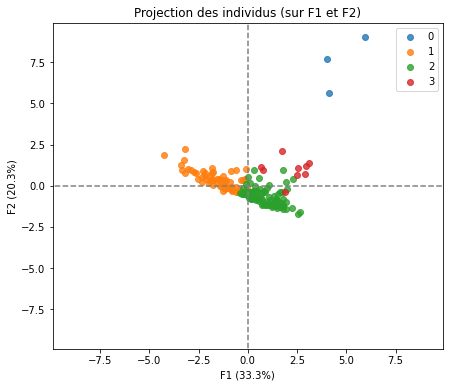

In [143]:
# display the data points in their clusters with Kmeans
display_factorial_planes(X_trans, 2, pca, [(0,1)], 
                         illustrative_var = data_with_clusters_KM.clusters_KM, alpha = 0.8)

## ACP sur les clusters du CAH

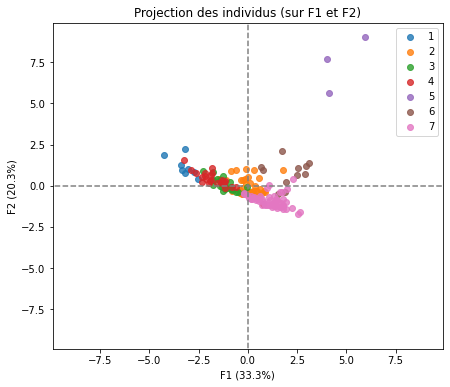

In [144]:
# display the data points in their clusters with CAH
display_factorial_planes(X_trans, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)


## Comparaison des projections des clusters du CAH et du Kmeans

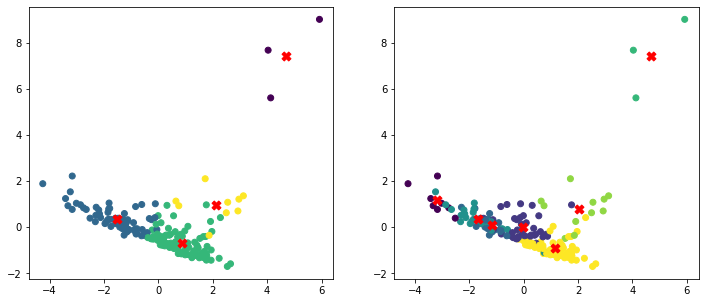

In [145]:
# Projection des clusters et de leurs centroides
fig=plt.figure(figsize=(12,5))
# clusters du Kmeans
ax=fig.add_subplot(121)
ax.scatter(X_trans[:,0],X_trans[:,1], c=cls4.labels_)

# creation des centroides Kmeans
centroids = cls4.cluster_centers_
centroids_projected = pca.transform(centroids)
ax.scatter(centroids_projected[:,0],centroids_projected[:,1],marker="X", c="r", s=80, label="centroids")

# clusters du CAH
ax=fig.add_subplot(122)
ax.scatter(X_trans[:,0],X_trans[:,1], c=data_with_clusters_CAH.clusters)

# moyennes des clusters CAH projetées
means_projected = pca.transform(means)
ax.scatter(means_projected[:,0],means_projected[:,1],marker="X", c="r", s=80, label="means")